In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import run_streamer
%pylab inline
import pandas as pd
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [3]:
rcParams['figure.figsize'] = (10,8)

In [4]:
def calculate_combined(table):
    table['COMBINEDup'] = table.ix[:,('LWup','SWup')].sum(axis=1)
    table['COMBINEDdown'] = table.ix[:,('LWdown','SWdown')].sum(axis=1)
    return table.ix[:,('COMBINEDup','COMBINEDdown','net')]

In [5]:
def save_table(table, name):
    with open('table_data/'+name, 'w') as td:
        td.write('\n\\midrule\n'.join(table.to_latex().splitlines()[-4:-2])+'\n')
    return table

In [6]:
def get_table(name, band, save=False, **user_settings):
    settings = {'Tropical':run_streamer.TROPICAL, 'Arctic':run_streamer.ARCTIC}[name].copy()
    settings.update({'SW':run_streamer.SW,'LW':run_streamer.LW,'COMBINED':run_streamer.COMBINED}[band])
    settings.update(user_settings)
    table = run_streamer.run_and_parse('./streamer','./template.inp',**settings)[0]
    table = table.ix[[100,0]]
    table.index = ['TOA','SFC']
    if band == 'COMBINED':
        table = calculate_combined(table)
    table.columns = pd.MultiIndex.from_product([[name],table.columns])
    table = table.rename(columns={'net':(band+'net')})
    table = table.ix[:,[(name,band+'up'),(name,band+'down'),(name,band+'net')]]
    filename = (name+band+'_'
                +str(user_settings)[1:-1].strip()
                .replace("'",'')
                .replace(':','_')
                .replace(', ','_')
                .replace(' ',''))+'.tex'
    if save:
        save_table(table, filename)
    return table

In [7]:
def get_spectral_flux(name, level, **user_settings):
    settings = {'Tropical':run_streamer.TROPICAL, 'Arctic':run_streamer.ARCTIC}[name].copy()
    settings.update(run_streamer.SPECTRAL)
    settings.update(user_settings)
    tables = run_streamer.run_and_parse('./streamer','./template.inp',**settings)
    bandwidth = lambda x: abs(1/(x[0]*100.)*1e6 - 1/(x[1]*100.)*1e6)
    spectral_flux = pd.DataFrame([{'up':(table.ix[level,'LWup']+table.ix[level,'SWup'])/bandwidth(band),
                                   'down':(table.ix[level,'LWdown']+table.ix[level,'SWdown'])/bandwidth(band),
                                   'net':table.ix[level,'net']/bandwidth(band)
                                  } for band, table in zip(run_streamer.BANDS,tables)],
                                index=[1e6/(sum(band)/2.0*100) for band in run_streamer.BANDS])
    spectral_flux[:] = spectral_flux.values * spectral_flux.index[:,np.newaxis]
    return spectral_flux

In [129]:
def plot_flux(sfc_flux, toa_flux):

    sfc_flux = sfc_flux.sort_index()
    sfc_flux.up *= -1
    sfc_flux.ix[:,('down',)].rename(columns=lambda x: 'SFC '+x).plot(
        #kind='area',
        linestyle='-',
        logx=True,
        color='r',
        stacked=False,
        ax=gca()
    )
    sfc_flux.ix[:,('up',)].rename(columns=lambda x: 'SFC '+x).plot(
        #kind='area',
        linestyle='--',
        logx=True,
        color='r',
        stacked=False,
        ax=gca()
    )
    sfc_flux.net.plot(kind='area',ax=gca(), color='darkred', legend=True,stacked=False)

    toa_flux = toa_flux.sort_index()
    toa_flux.up *= -1
    toa_flux.ix[:,('down',)].rename(columns=lambda x: 'TOA '+x).plot(
        #kind='area',
        linestyle='-',
        logx=True,
        color='b',
        stacked=False,
        ax=gca())
    toa_flux.ix[:,('up',)].rename(columns=lambda x: 'TOA '+x).plot(
        #kind='area',
        linestyle='--',
        logx=True,
        color='b',
        stacked=False,
        ax=gca())
    toa_flux.net.plot(kind='area',ax=gca(), linewidth=3, color='darkblue', legend=True, stacked=False)

    xlim([.28,100])
    ylim([-400,400])
    ylabel('$\lambda F_{\lambda}$ [W m$^{-2}$]')
    xlabel('Wavelength [$\mu$m]')
    gca().set_xticks([.28,.6,1,2,5,10,20,50,100])
    gca().set_xticklabels([.28,.6,1,2,5,10,20,50,100])
    grid()

In [9]:
def get_heating(name, **user_settings):
    band_heatings = []
    settings = {'Tropical':run_streamer.TROPICAL, 'Arctic':run_streamer.ARCTIC}[name].copy()
    settings.update(user_settings)
    for band in ['SW','LW','COMBINED']:
        settings.update({'SW':run_streamer.SW,'LW':run_streamer.LW,'COMBINED':run_streamer.COMBINED}[band])
        table = run_streamer.run_and_parse('./streamer','./template.inp',**settings)[0]
        heating_rate = table.heating_rate.ix[:1]
        heating_rate.name = band+'Heating'
        band_heatings.append(heating_rate)
    return pd.DataFrame(band_heatings).T

In [10]:
def plot_heating(name, **settings):
    heating = get_heating(name, **settings)
    plot(heating.SWHeating.values, heating.SWHeating.index, label='SW')
    plot(heating.LWHeating.values, heating.LWHeating.index, label='LW')
    plot(heating.COMBINEDHeating.values, heating.COMBINEDHeating.index, label='Net')
    ylim([0,50])
    xlim([-7,3])
    vlines(0, *ylim())
    legend(loc='best')
    title(name+' Heating Rate')
    ylabel('Height (km)')
    grid()
    xlabel('Heating Rate ($\degree$K/day)')

In [122]:
def plot_heating_forcing(name, **settings):
    baseline = get_heating(name)
    heating = get_heating(name, **settings)
    forcing = (heating - baseline)
    plot(forcing.SWHeating.values, forcing.SWHeating.index, label='SW')
    plot(forcing.LWHeating.values, forcing.LWHeating.index, label='LW')
    plot(forcing.COMBINEDHeating.values, forcing.COMBINEDHeating.index, label='Net')
    ylim([0,50])
    xlim([-8,8])
    vlines(0, *ylim())
    legend(loc='best')
    title(name+' Heating Rate')
    ylabel('Height (km)')
    grid()
    xlabel('Heating Rate ($\degree$K/day)')

In [11]:
def get_spectral_heating(name, **user_settings):
    settings = {'Tropical':run_streamer.TROPICAL, 'Arctic':run_streamer.ARCTIC}[name].copy()
    settings.update(run_streamer.SPECTRAL)
    settings.update(user_settings)
    bandwidth = lambda x: abs(1/(x[0]*100.)*1e6 - 1/(x[1]*100.)*1e6)
    tables = run_streamer.run_and_parse('./streamer','./template.inp',**settings)
    spectral_heating = pd.DataFrame([table.heating_rate / bandwidth(band) 
                                     for band, table in zip(run_streamer.BANDS, tables)],
                                index=[1e6/(sum(band)/2.0*100) for band in run_streamer.BANDS])
    return spectral_heating.T

In [12]:
def plot_spectral_heating(name, **settings):
    import math
    heating = get_spectral_heating(name, **settings).sort_index().sort_index(axis=1).ix[:50,.3:50]
    max_zvalue = math.ceil(max(abs(heating.values.min().min()), abs(heating.values.max().max())))
    zvalues = np.linspace(-max_zvalue, max_zvalue, 101)
    contourf(heating.columns.values, heating.index.values, heating.values,zvalues,cmap='seismic')
    gca().set_xscale("log")
    gca().set_xticks([.3,.6,1,2,5,10,20,50])
    gca().set_xticklabels([.3,.6,1,2,5,10,20,50])
    title(name+' Heating Rate [K/day/$\mu m$]')
    ylabel('Z (km)')
    xlabel('Wavelength [$\mu m$]')
    colorbar()

# Arctic
### SW

In [18]:
get_table('Arctic','SW', save=True)

Arctic               
      SWup  SWdown  SWnet
TOA  57.98  144.74  86.76
SFC  21.15   81.99  60.84

### LW

In [19]:
get_table('Arctic','LW', save=True)

Arctic                
       LWup  LWdown   LWnet
TOA  170.99    0.00 -170.99
SFC  194.25  134.55  -59.70

### Combined

In [20]:
get_table('Arctic','COMBINED', save=True)

Arctic                         
    COMBINEDup COMBINEDdown COMBINEDnet
TOA     228.97       144.74      -84.23
SFC     215.40       216.54        1.14

### Spectral Flux

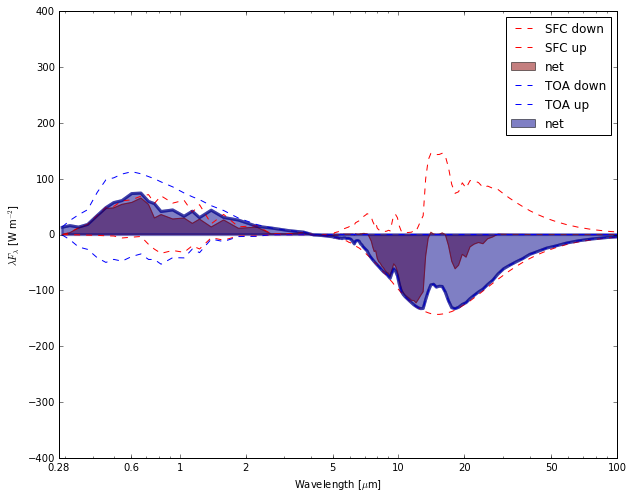

In [101]:
plot_flux(get_spectral_flux('Arctic',0), get_spectral_flux('Arctic',100))

### Heating Rates

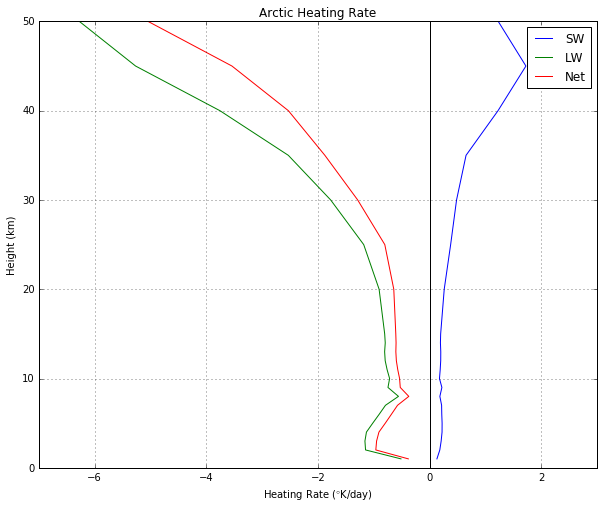

In [54]:
plot_heating('Arctic')

### Spectral Heating Rates

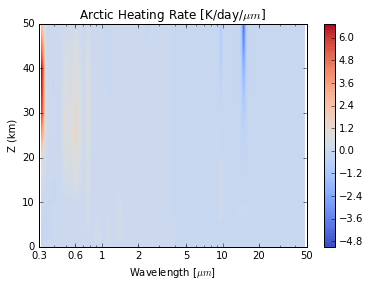

In [23]:
plot_spectral_heating('Arctic')

## 3
Radiative forcing is defined as the change in radiative flux that results from making a particular change to the atmosphere.  For both the tropical atmosphere and the polar atmosphere, repeat the above calculations, but with the following changes each made in turn:
1. 10% increase in water vapor amount everywhere in the column. This means simultaneously increasing both the WV and the WV continuum parameters.
2. Double CO2 concentration.
3. 50% reduction in ozone concentration.
4. Add liquid water cloud layer (cloudphase1 = 0 ) with optical thickness 10.0 and base at 1.0 km.
4. Same as above, but moving the cloud layer to 10.0 km and changing the cloud particle type to “spherical ice”  (cloudphase1 = 8 )


For each of the above changes, plot or tabulate the associated changes (relative to the baseline case) in the fluxes and heating profiles. NOTE: For cloud experiments you will need to make the following changes to your input file:
Change icthk (second to last value in the 13th input line) to 3, so that cloud thickness is specified in optical units.
Change cldwcl (last element in the cloud properties line) to 0.07 to ensure that cloud water density remains within the allowable range for both the low and high cloud layer.

# Increase water vapor 10%
## Arctic

### SW

In [24]:
save_table(get_table('Arctic','SW',frwv=1.1, frwv2=1.1) - get_table('Arctic','SW'), 'ArcticSWwv.tex')

Arctic             
      SWup SWdown SWnet
TOA  -0.12   0.00  0.13
SFC  -0.10  -0.28 -0.18

It appears that increasing water vapor only slightly affects the fluxes at the surface or TOA in the Arctic.

### LW

In [25]:
save_table(get_table('Arctic','LW',frwv=1.1, frwv2=1.1) - get_table('Arctic','LW'), 'ArcticLWwv.tex')

Arctic             
      LWup LWdown LWnet
TOA  -0.32   0.00  0.32
SFC   0.00   1.32  1.31

Likewise, the longwave radiative flux is mostly unaffected by increasing water vapor.

### Combined

In [26]:
save_table(get_table('Arctic','COMBINED',frwv=1.1, frwv2=1.1) - get_table('Arctic','COMBINED'), 'ArcticCOMwv.tex')

Arctic                         
    COMBINEDup COMBINEDdown COMBINEDnet
TOA      -0.44         0.00        0.45
SFC      -0.10         1.04        1.13

The combined effect is insignificant too.

### Spectral Flux

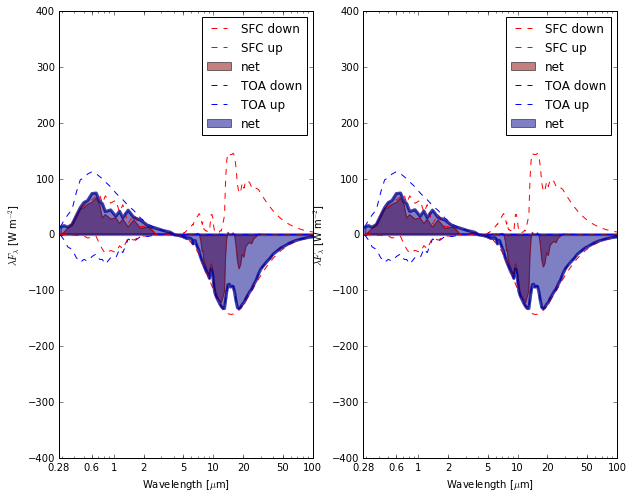

In [160]:
subplot(121)
plot_flux(get_spectral_flux('Arctic',0),get_spectral_flux('Arctic',100))
subplot(122)
plot_flux(get_spectral_flux('Arctic',0,frwv=1.1,frwv2=1.1),get_spectral_flux('Arctic',100,frwv=1.1,frwv2=1.1))

Little to no effect

### Heating Rates

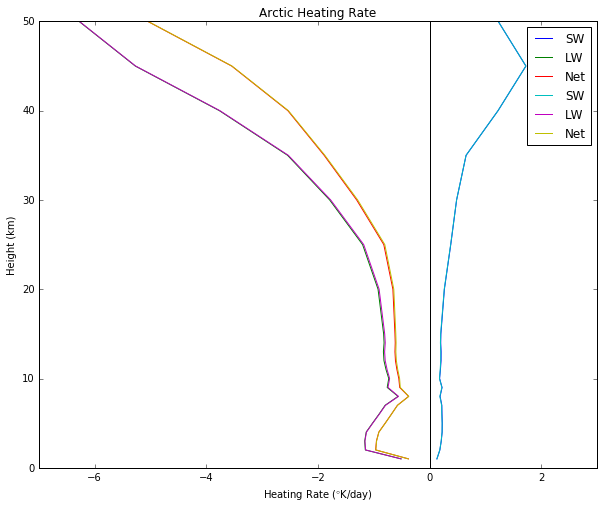

In [56]:
plot_heating('Arctic', frwv=1.1, frwv2=1.1)
plot_heating('Arctic')

Basically no change in heating rates.

### Spectral Heating Rates

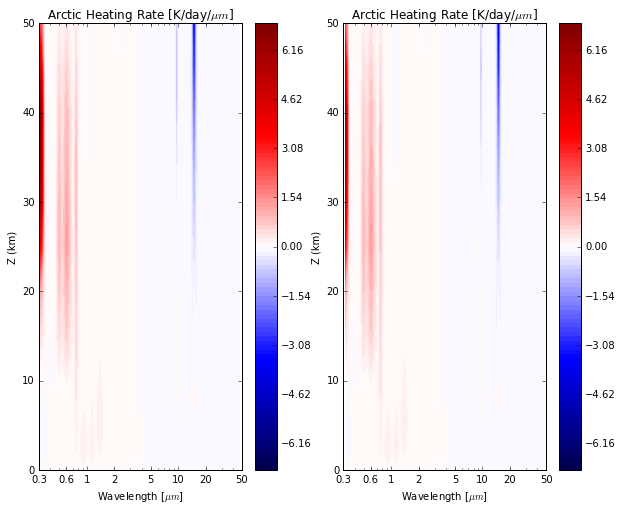

In [162]:
subplot(121)
plot_spectral_heating('Arctic')
subplot(122)
plot_spectral_heating('Arctic', frwv=1.1, frwv2=1.1)

No change in spectral heating too

# Double CO2 Concentration

### SW

In [52]:
save_table(get_table('Arctic','SW',frco2=2.0) - get_table('Arctic','SW'), 'ArcticSWco2.tex')

Arctic             
      SWup SWdown SWnet
TOA  -0.07   0.00  0.08
SFC  -0.06  -0.26 -0.21

Doubling CO2 has a negligible effect on shortwave fluxes

### LW

In [29]:
save_table(get_table('Arctic','LW',frco2=2.0) - get_table('Arctic','LW'), 'ArcticLWco2.tex')

Arctic             
      LWup LWdown LWnet
TOA  -0.87   0.00  0.87
SFC   0.00   1.77  1.77

It does seem to slightly increase the downwelling longwave radiation at the surface

### Combined

In [30]:
save_table(get_table('Arctic','COMBINED',frco2=2.0) - get_table('Arctic','COMBINED'), 'ArcticCOMBco2.tex')

Arctic                         
    COMBINEDup COMBINEDdown COMBINEDnet
TOA      -0.94         0.00        0.95
SFC      -0.06         1.51        1.56

No effect

### Spectral Flux

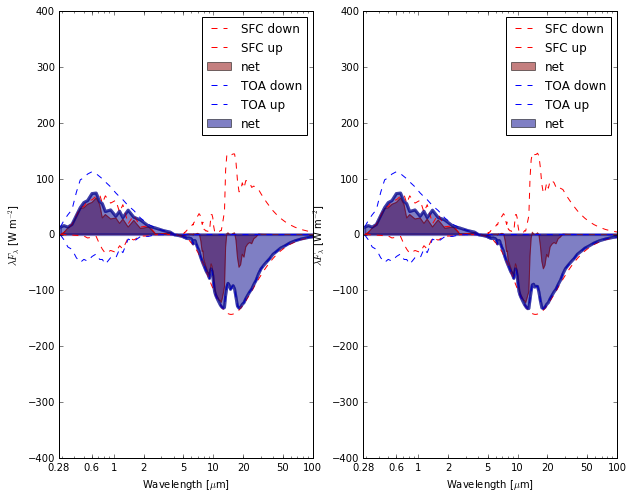

In [163]:
subplot(121)
plot_flux(get_spectral_flux('Arctic',0,frco2=2.0),get_spectral_flux('Arctic',100,frco2=2.0))
subplot(122)
plot_flux(get_spectral_flux('Arctic',0),get_spectral_flux('Arctic',100))

### Heating Rates

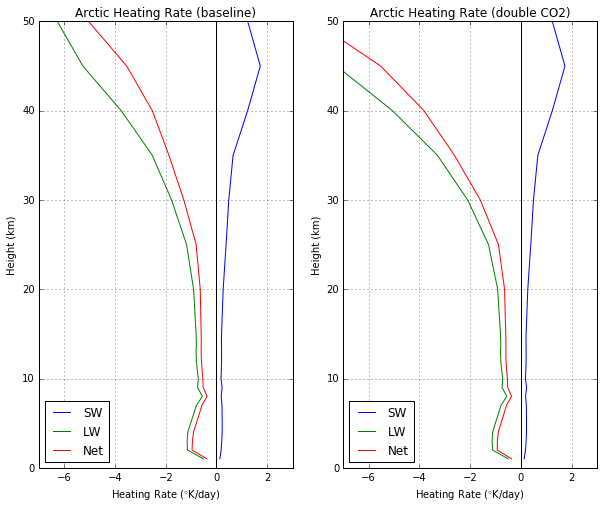

In [76]:
subplot(121)
plot_heating('Arctic')
title('Arctic Heating Rate (baseline)')
subplot(122)
plot_heating('Arctic', frco2=2)
title('Arctic Heating Rate (double CO2)')

SW heating rate is unchanged since CO2 is transparent, so doubling the concentration has little effect. The LW heating rate is dramatically decreased above 20km.

### Spectral Heating Rates

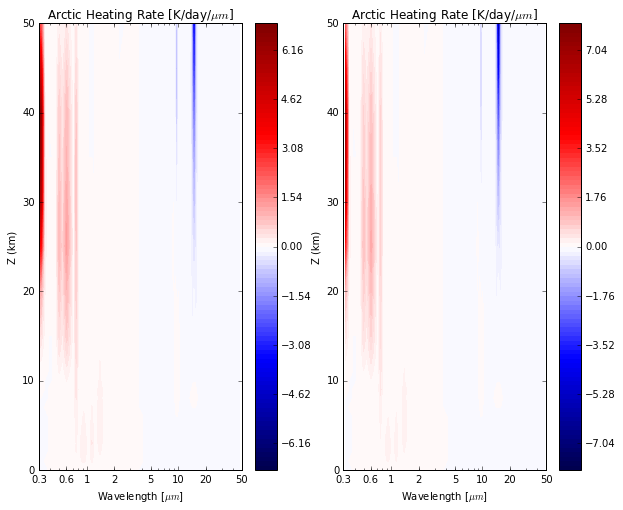

In [164]:
subplot(121)
plot_spectral_heating('Arctic')
subplot(122)
plot_spectral_heating('Arctic', frco2=2.0)

I don't even know

# Reduce O3 by 50%

### SW

In [79]:
save_table(get_table('Arctic','SW',fro3=0.5) - get_table('Arctic','SW'), 'ArcticSWo3.tex')

Arctic             
      SWup SWdown SWnet
TOA   0.91   0.00 -0.91
SFC   0.07   1.01  0.95

No effect

### LW

In [33]:
save_table(get_table('Arctic','LW',fro3=0.5) - get_table('Arctic','LW'), 'ArcticLWo3.tex')

Arctic             
      LWup LWdown LWnet
TOA   0.71   0.00 -0.71
SFC   0.00  -0.86 -0.87

No effect

### Combined

In [34]:
save_table(get_table('Arctic','COMBINED',fro3=0.5) - get_table('Arctic','COMBINED'), 'ArcticCOMBo3.tex')

Arctic                         
    COMBINEDup COMBINEDdown COMBINEDnet
TOA       1.62         0.00       -1.61
SFC       0.07         0.15        0.08

The small increases in upwelling longwave and shortwave radiation seem combine additively to slightly increase the loss of radiative energy at the TOA.

### Spectral Flux

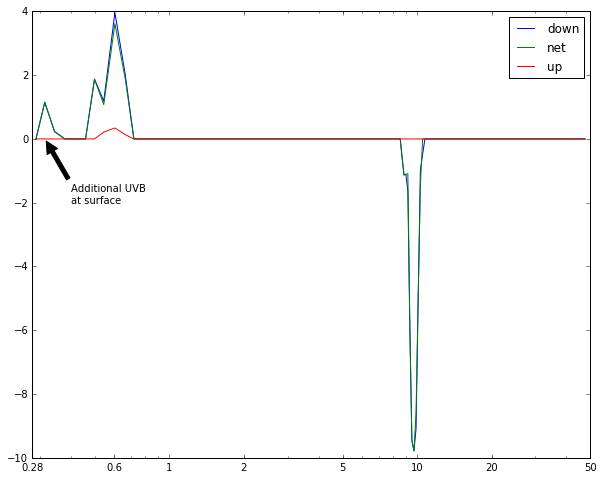

In [81]:
(get_spectral_flux('Arctic',0,fro3=0.5) - get_spectral_flux('Arctic',0)).sort_index().ix[:50].plot()
gca().set_xscale("log")
gca().set_xticks([.28,.6,1,2,5,10,20,50])
_ = gca().set_xticklabels([.28,.6,1,2,5,10,20,50])
annotate('Additional UVB\nat surface', xy=(.315, 0), xytext=(.4, -2),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )

### Heating Rates

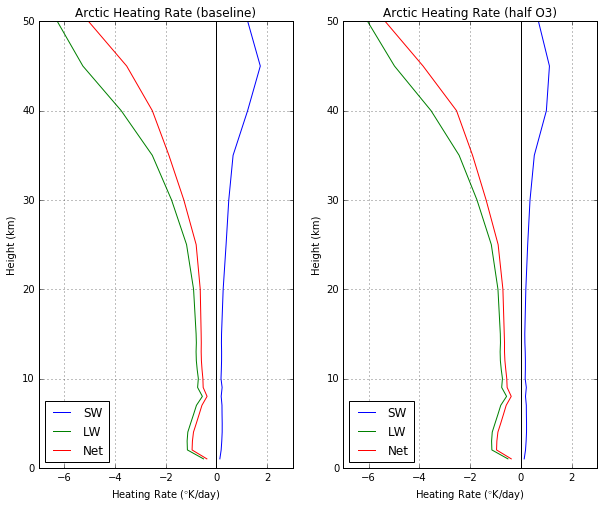

In [82]:
subplot(121)
plot_heating('Arctic')
title('Arctic Heating Rate (baseline)')
subplot(122)
plot_heating('Arctic', fro3=0.5)
title('Arctic Heating Rate (half O3)')

SW heating rate is decreased above 40km, where ozone absorbs UV radiation. Less ozone means more makes it deeper in the atmosphere

### Spectral Heating Rates

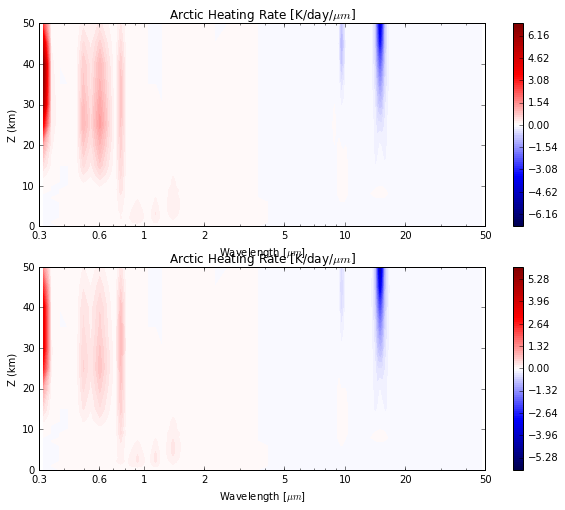

In [96]:
subplot(211)
plot_spectral_heating('Arctic')
subplot(212)
plot_spectral_heating('Arctic', fro3=0.5)

# Add liquid water cloud layerwith optical thickness 10.0 and base at 1.0 km

In [141]:
cloud_settings = dict(nclouds=1, icthk=3, cldwcl=0.07, cldphase1=0, cldtau=10.0, cldtop=1.0)

### SW

In [37]:
save_table(get_table('Arctic','SW', **cloud_settings) 
 - get_table('Arctic','SW'), 'ArcticSWcloud1.tex')

Arctic              
      SWup SWdown  SWnet
TOA  35.27   0.00 -35.26
SFC -12.40 -47.99 -35.60

### LW

In [38]:
save_table(get_table('Arctic','LW',**cloud_settings) 
 - get_table('Arctic','LW'), 'ArcticLWcloud1.tex')

Arctic              
      LWup LWdown  LWnet
TOA   8.31   0.00  -8.31
SFC   0.00  77.48  77.48

### Combined

In [39]:
save_table(get_table('Arctic','COMBINED',**cloud_settings) 
 - get_table('Arctic','COMBINED'), 'ArcticCOMBcloud1.tex')

Arctic                         
    COMBINEDup COMBINEDdown COMBINEDnet
TOA      43.58         0.00      -43.57
SFC     -12.40        29.49       41.88

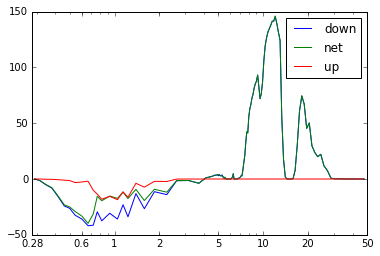

In [40]:
(get_spectral_flux('Arctic',0,**cloud_settings) 
 - get_spectral_flux('Arctic',0)).sort_index().ix[:50].plot()
gca().set_xscale("log")
gca().set_xticks([.28,.6,1,2,5,10,20,50])
_ = gca().set_xticklabels([.28,.6,1,2,5,10,20,50])

### Spectral Flux

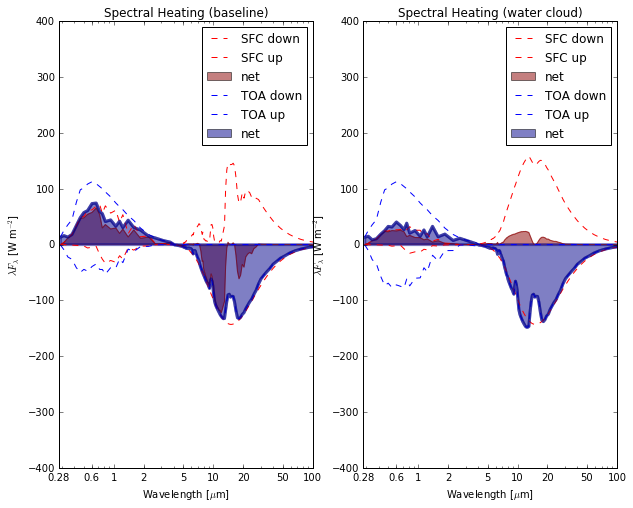

In [143]:
subplot(121)
plot_flux(get_spectral_flux('Arctic',0), get_spectral_flux('Arctic',100))
title('Spectral Heating (baseline)')
subplot(122)
plot_flux(get_spectral_flux('Arctic',0,**cloud_settings), get_spectral_flux('Arctic',100,**cloud_settings))
title('Spectral Heating (water cloud)')

Significantly more downwelling longwave radiation at the surface, possibly explaining the increased upwelling longwave radiation at the TOA. Also more upwelling shortwave radiation at surface and TOA.

### Heating Rates

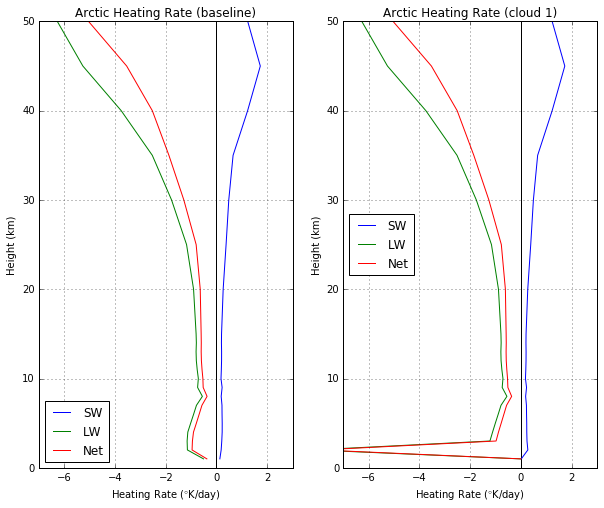

In [102]:
subplot(121)
plot_heating('Arctic')
title('Arctic Heating Rate (baseline)')
subplot(122)
plot_heating('Arctic', **cloud_settings)
title('Arctic Heating Rate (cloud 1)')

There is a drastic decrease in LW heating rate directly above the cloud.

### Spectral Heating Rates

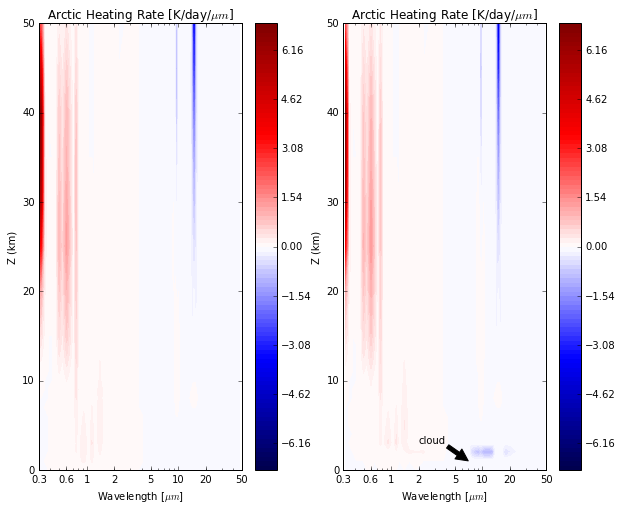

In [152]:
subplot(121)
plot_spectral_heating('Arctic')
subplot(122)
plot_spectral_heating('Arctic', **cloud_settings)
annotate('cloud', xy=(7,1), xytext=(2, 3), arrowprops=dict(facecolor='black'))

The cloud seems to mainly affect the heating rate above the cloud. A decrease in heating is observed in the spectral range from ~7um to ~14um

# Moving the cloud layer to 10.0 km and changing the cloud particle type to “spherical ice”

In [119]:
cloud_settings2 = dict(nclouds=1, icthk=3, cldwcl=0.07, cldphase1=8, cldtau=10.0, cldtop=10.0)

### SW

In [120]:
save_table(get_table('Arctic','SW', **cloud_settings2) 
 - get_table('Arctic','SW'), 'ArcticSWcloud2.tex')

Arctic              
      SWup SWdown  SWnet
TOA  43.00   0.00 -43.00
SFC -11.97 -46.62 -34.65

More upwelling shortwave at TOA, probably from higher albedo caused by cloud.
Decrease in downwelling shortwave at surface. Probably because in the shadow of the cloud it is a bit dimmer.

### LW

In [121]:
save_table(get_table('Arctic','LW',**cloud_settings2) 
 - get_table('Arctic','LW'),'ArcticLWcloud2.tex')

Arctic              
      LWup LWdown  LWnet
TOA  -51.8   0.00  51.80
SFC    0.0  36.11  36.11

Large decrease of upwelling longwave at TOA, probably because the cloud is absorbing it.
Increase in downwelling longwave, cloud cover probably traps heat, increasing temperatures in lower atmosphere.

### Combined

In [122]:
save_table(get_table('Arctic','COMBINED',**cloud_settings2) 
 - get_table('Arctic','COMBINED'), 'ArcticCOMBcloud2.tex')

Arctic                         
    COMBINEDup COMBINEDdown COMBINEDnet
TOA      -8.80         0.00        8.80
SFC     -11.97       -10.51        1.46

Effects cancel out

### Spectral Flux

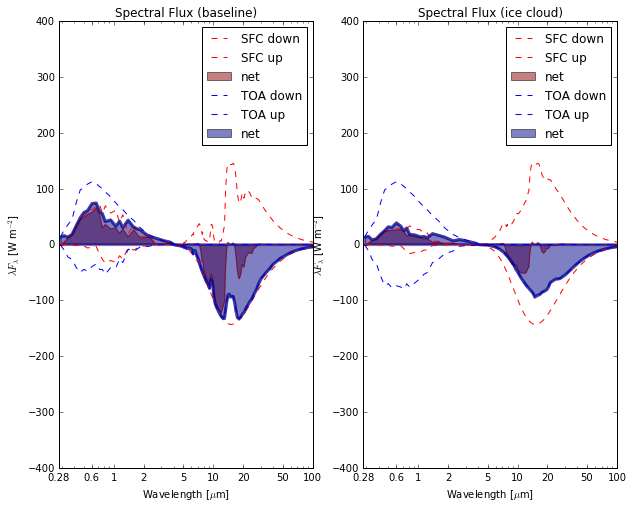

In [144]:
subplot(122)
plot_flux(get_spectral_flux('Arctic',0,**cloud_settings2),
          get_spectral_flux('Arctic',100,**cloud_settings2))
title('Spectral Flux (ice cloud)')
subplot(121)
plot_flux(get_spectral_flux('Arctic',0),
          get_spectral_flux('Arctic',100))
title('Spectral Flux (baseline)')

Effect on the shortwave looks very similar to the effect from the low cloud.
Dimmer at the surface, more incoming light being reflected back out to space.
This time we see decreased longwave upwelling radiation at the TOA. Without clouds only a few absorption bands existed, most of the upwelling longwave from the surface seemed to make it to the TOA. With the ice cloud, much of the longwave appears to be from emission from the cloud. Much more of the of the longwave emitted from the surface is "reflected" off the cloud. 

### Heating Rates

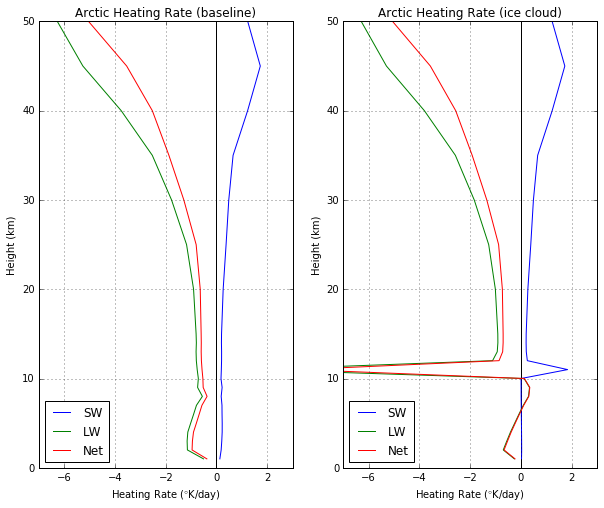

In [146]:
subplot(121)
plot_heating('Arctic')
title('Arctic Heating Rate (baseline)')
subplot(122)
plot_heating('Arctic', **cloud_settings2)
title('Arctic Heating Rate (ice cloud)')

There is a drastic decrease in LW heating rate directly above the cloud and an increase below, indicating absorption of LW by the cloud.
There is also a spike in heating rate from SW above the cloud because it is absorbing some of it.

### Spectral Heating Rates

(9, 15)

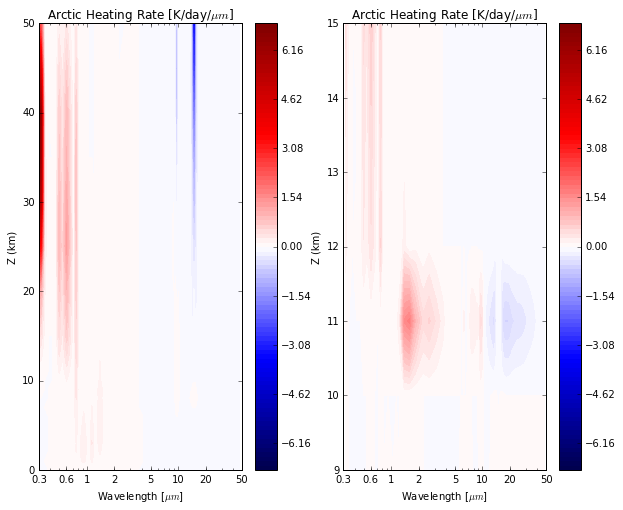

In [153]:
subplot(121)
plot_spectral_heating('Arctic')
subplot(122)
plot_spectral_heating('Arctic', **cloud_settings2)
ylim([9,15])

You can see the increase in heating at about 1.5um, in the NIR. Cloud are probably have higher absorbtion at that wavelength, whereas visible light is reflected. You can also see that the LW heating above the cloud is decreased because the cloud is absorbing, though there is a portion of longwave heating at 10um not seen in the water cloud.

# Tropical
### SW

In [12]:
get_table('Tropical','SW',save=True)

Tropical                
        SWup  SWdown   SWnet
TOA    125.0  450.83  325.83
SFC     70.9  304.04  233.15

Some shortwave is absorbed between TOA and SFC, but not much.
SWup at TOA probably contains both sw off clouds and from surface.

### LW

In [46]:
get_table('Tropical','LW',save=True)

Tropical                
        LWup  LWdown   LWnet
TOA   290.06    0.00 -290.06
SFC   458.22  395.98  -62.24

Here we have much more longwave exiting at the TOA.

### Combined

In [14]:
get_table('Tropical','COMBINED', save=True)

Tropical                         
    COMBINEDup COMBINEDdown COMBINEDnet
TOA     415.06       450.83       35.77
SFC     529.12       700.02      170.91

There is more flux being absorbed than emitted.

### Spectral Flux

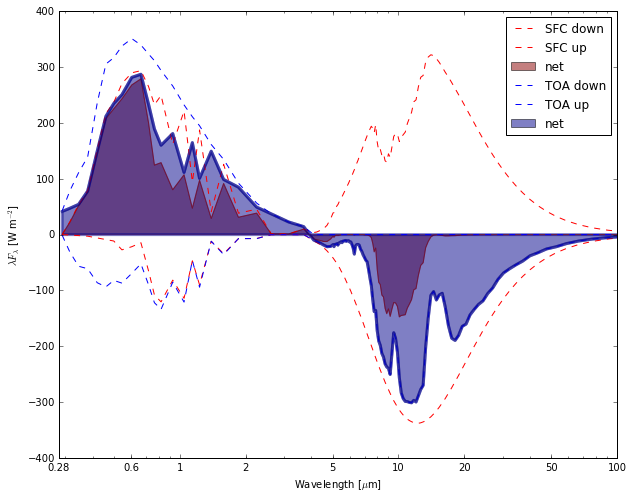

In [48]:
plot_flux(get_spectral_flux('Tropical',0), get_spectral_flux('Tropical',100))

Surface LW emission looks like a blackbody. Incoming LW radiation looks like blackbodies at different temperatures, with some colder emission in certain windows around 10um. No LW down at TOA.

In SW both TOA and SFC look similar. Reflecting a small portion of downwelling radiation back up.

### Heating Rates

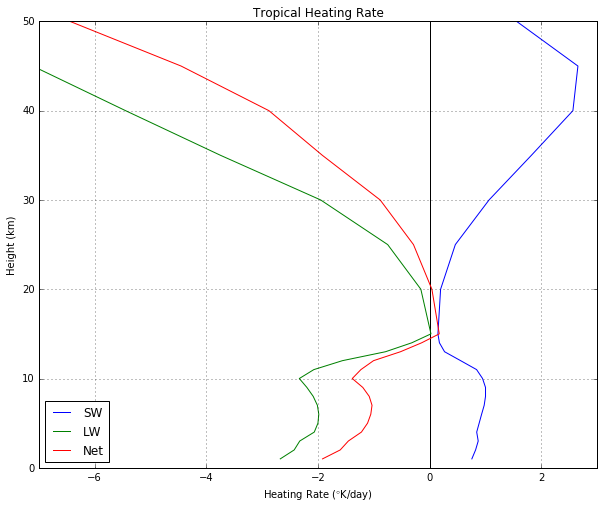

In [66]:
plot_heating('Tropical')

Slight heating at ~15 km height, but mostly cooling. Makes sense sun is low in the sky.

### Spectral Heating Rates

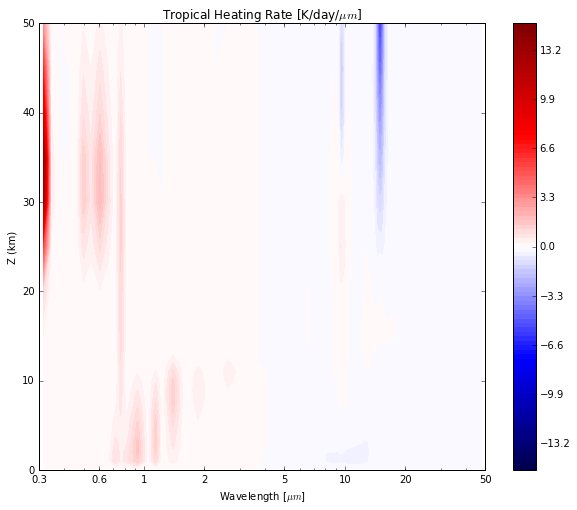

In [97]:
plot_spectral_heating('Tropical')

# Increase water vapor 10%

### SW

In [154]:
save_table(get_table('Tropical','SW',frwv=1.1, frwv2=1.1) - get_table('Tropical','SW'), 'TropicalSWwv.tex')

Tropical             
        SWup SWdown SWnet
TOA    -0.42    0.0  0.42
SFC    -0.44   -1.2 -0.77

It appears that increasing water vapor only slightly affects the fluxes at the surface or TOA in the tropics in this case.

### LW

In [155]:
save_table(get_table('Tropical','LW',frwv=1.1, frwv2=1.1) - get_table('Tropical','LW'), 'TropicalLWwv.tex')

Tropical             
        LWup LWdown LWnet
TOA    -2.84   0.00  2.84
SFC     0.00   7.47  7.47

See a little more downwelling at the surface

### Combined

In [156]:
save_table(get_table('Tropical','COMBINED',frwv=1.1, frwv2=1.1) - get_table('Tropical','COMBINED'), 'TropicalCOMwv.tex')

Tropical                         
    COMBINEDup COMBINEDdown COMBINEDnet
TOA      -3.26         0.00        3.25
SFC      -0.44         6.27        6.70

The combined effect is insignificant too.

### Spectral Flux

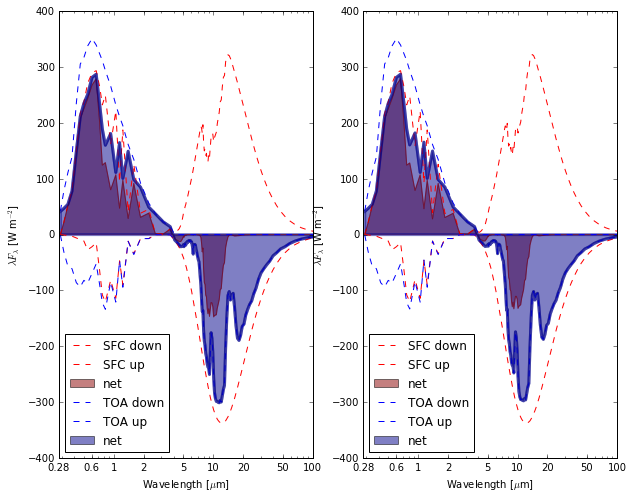

In [157]:
subplot(121)
plot_flux(get_spectral_flux('Tropical',0),get_spectral_flux('Tropical',100))
subplot(122)
plot_flux(get_spectral_flux('Tropical',0,frwv=1.1,frwv2=1.1),get_spectral_flux('Tropical',100,frwv=1.1,frwv2=1.1))

No noticable effect

### Heating Rates

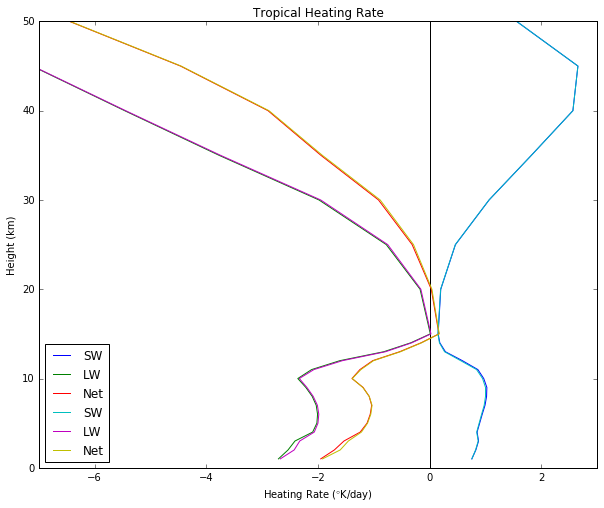

In [165]:
plot_heating('Tropical', frwv=1.1, frwv2=1.1)
plot_heating('Tropical')

Basically no change in heating rates.

### Spectral Heating Rates

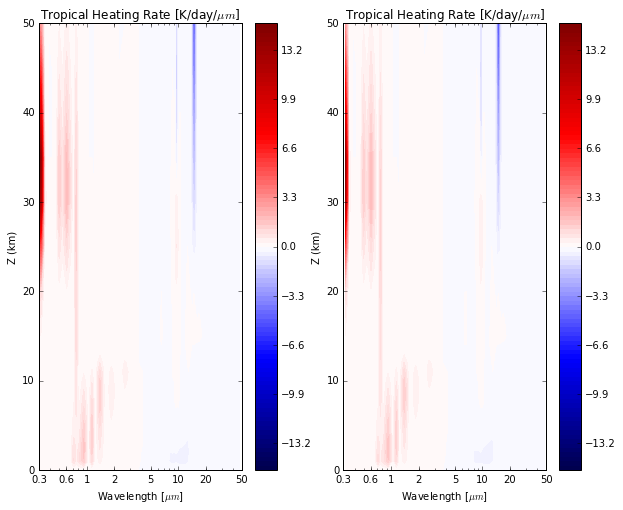

In [167]:
subplot(121)
plot_spectral_heating('Tropical')
subplot(122)
plot_spectral_heating('Tropical', frwv=1.1, frwv2=1.1)

No change in spectral heating too

# Double CO2 Concentration

### SW

In [168]:
save_table(get_table('Tropical','SW',frco2=2.0) - get_table('Tropical','SW'), 'TropicalSWco2.tex')

Tropical             
        SWup SWdown SWnet
TOA    -0.13   0.00  0.13
SFC    -0.12  -0.52 -0.41

Doubling CO2 has a negligible effect on shortwave fluxes

### LW

In [169]:
save_table(get_table('Tropical','LW',frco2=2.0) - get_table('Tropical','LW'), 'TropicalLWco2.tex')

Tropical             
        LWup LWdown LWnet
TOA    -2.36   0.00  2.36
SFC     0.00   0.46  0.46

Slight decrease in the upwelling longwave radiation at TOA

### Combined

In [170]:
save_table(get_table('Tropical','COMBINED',frco2=2.0) - get_table('Tropical','COMBINED'), 'TropicalCOMBco2.tex')

Tropical                         
    COMBINEDup COMBINEDdown COMBINEDnet
TOA      -2.49         0.00        2.49
SFC      -0.12        -0.06        0.05

No effect

### Spectral Flux

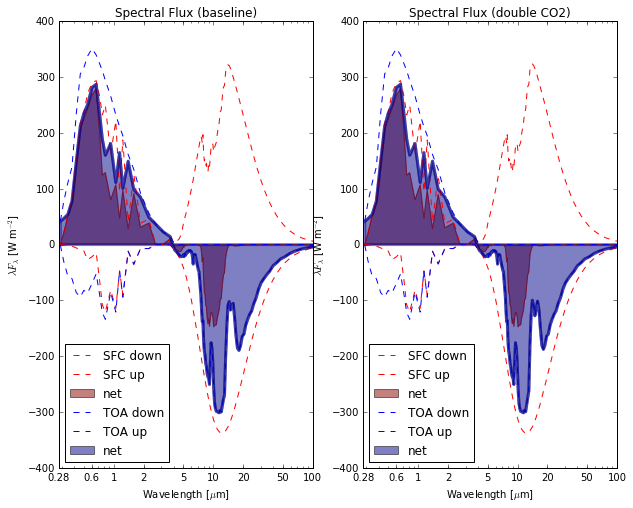

In [174]:
subplot(122)
plot_flux(get_spectral_flux('Tropical',0,frco2=2.0),
          get_spectral_flux('Tropical',100,frco2=2.0))
title('Spectral Flux (double CO2)')
subplot(121)
plot_flux(get_spectral_flux('Tropical',0),
          get_spectral_flux('Tropical',100))
title('Spectral Flux (baseline)')

No effect

### Heating Rates

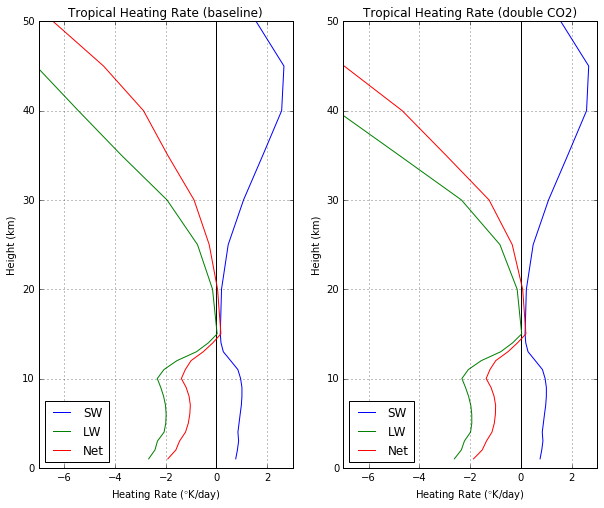

In [175]:
subplot(121)
plot_heating('Tropical')
title('Tropical Heating Rate (baseline)')
subplot(122)
plot_heating('Tropical', frco2=2)
title('Tropical Heating Rate (double CO2)')

SW heating rate is unchanged since CO2 is transparent, so doubling the concentration has little effect. The LW heating rate is dramatically decreased above 20km.

### Spectral Heating Rates

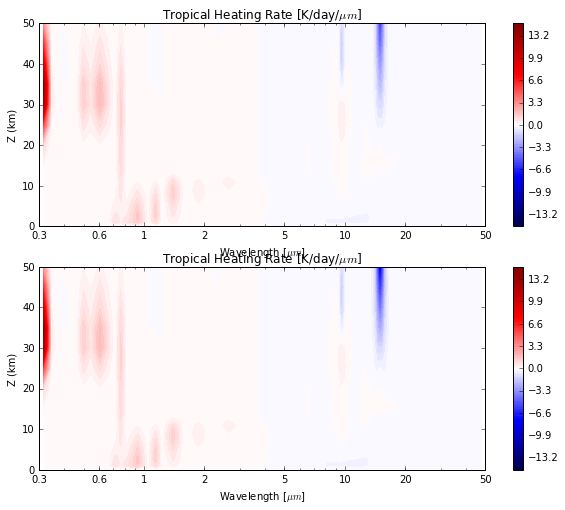

In [176]:
subplot(211)
plot_spectral_heating('Tropical')
subplot(212)
plot_spectral_heating('Tropical', frco2=2.0)

I don't even know

# Reduce O3 by 50%

### SW

In [177]:
save_table(get_table('Tropical','SW',fro3=0.5) - get_table('Tropical','SW'), 'TropicalSWo3.tex')

Tropical             
        SWup SWdown SWnet
TOA     0.93   0.00 -0.93
SFC     0.06   1.22  1.15

No effect

### LW

In [179]:
save_table(get_table('Tropical','LW',fro3=0.5) - get_table('Tropical','LW'), 'TropicalLWo3.tex')

Tropical             
        LWup LWdown LWnet
TOA     2.47   0.00 -2.47
SFC     0.00  -0.78 -0.79

No effect

### Combined

In [180]:
save_table(get_table('Tropical','COMBINED',fro3=0.5) - get_table('Tropical','COMBINED'), 'TropicalCOMBo3.tex')

Tropical                         
    COMBINEDup COMBINEDdown COMBINEDnet
TOA       3.40         0.00       -3.40
SFC       0.06         0.44        0.36

The small increases in upwelling longwave and shortwave radiation seem combine additively to slightly increase the loss of radiative energy at the TOA.

### Spectral Flux

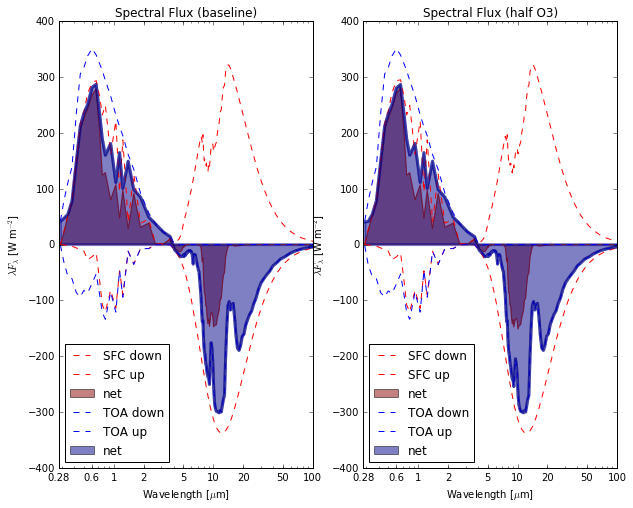

In [182]:
subplot(122)
plot_flux(get_spectral_flux('Tropical',0,fro3=0.5),
          get_spectral_flux('Tropical',100,fro3=0.5))
title('Spectral Flux (half O3)')
subplot(121)
plot_flux(get_spectral_flux('Tropical',0),
          get_spectral_flux('Tropical',100))
title('Spectral Flux (baseline)')

### Heating Rates

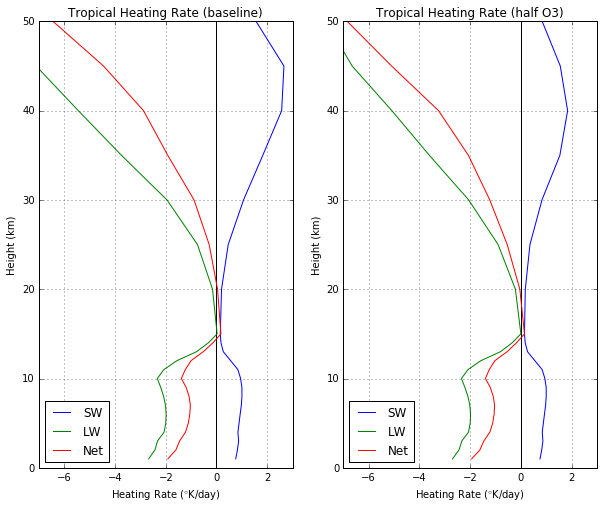

In [186]:
subplot(121)
plot_heating('Tropical')
title('Tropical Heating Rate (baseline)')
subplot(122)
plot_heating('Tropical', fro3=0.5)
title('Tropical Heating Rate (half O3)')

SW heating rate is decreased above 40km, where ozone absorbs UV radiation. Less ozone means more makes it deeper in the atmosphere

### Spectral Heating Rates

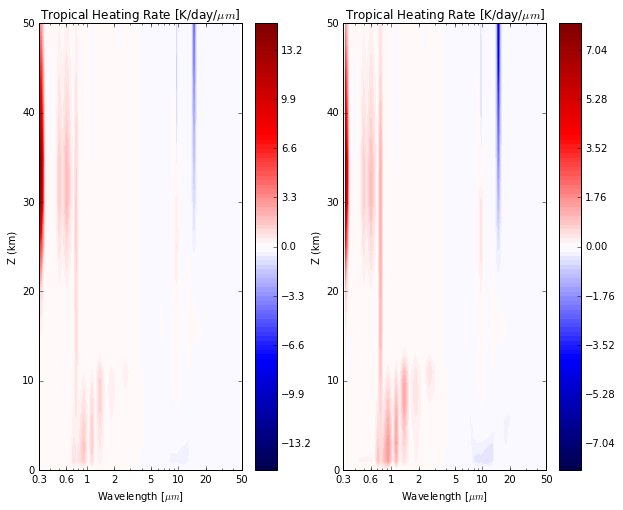

In [188]:
subplot(121)
plot_spectral_heating('Tropical')
subplot(122)
plot_spectral_heating('Tropical', fro3=0.5)

Much more heating from 25-45km at 0.3um wavelength

# Add liquid water cloud layerwith optical thickness 10.0 and base at 1.0 km

In [13]:
cloud_settings = dict(nclouds=1, icthk=3, cldwcl=0.07, cldphase1=0, cldtau=10.0, cldtop=1.0)

### SW

In [15]:
save_table(get_table('Tropical','SW', **cloud_settings) 
 - get_table('Tropical','SW'), 'ArcticSWcloud1.tex')

Tropical                
        SWup  SWdown   SWnet
TOA   128.73    0.00 -128.73
SFC   -38.34 -169.32 -130.99

Much more upwelling shortwave at TOA, probably reflected off the top of the cloud. At the surface it is much dimmer and by about the same amount that the TOA saw increase.

### LW

In [16]:
save_table(get_table('Tropical','LW',**cloud_settings) 
 - get_table('Tropical','LW'), 'ArcticLWcloud1.tex')

Tropical              
        LWup LWdown  LWnet
TOA   -14.57    0.0  14.57
SFC     0.00   49.2  49.20

There is an increase in downwelling longwave at the surface, probably seeing the warm cloud. The TOA is loses less longwave to space.

### Combined

In [39]:
save_table(get_table('Arctic','COMBINED',**cloud_settings) 
 - get_table('Arctic','COMBINED'), 'ArcticCOMBcloud1.tex')

Arctic                         
    COMBINEDup COMBINEDdown COMBINEDnet
TOA      43.58         0.00      -43.57
SFC     -12.40        29.49       41.88

The cloud appears to insulate the cold TOA from the warm surface. The surface gains additional influx of radiation, the atmosphere above the cloud loses more shortwave to space.

### Spectral Flux

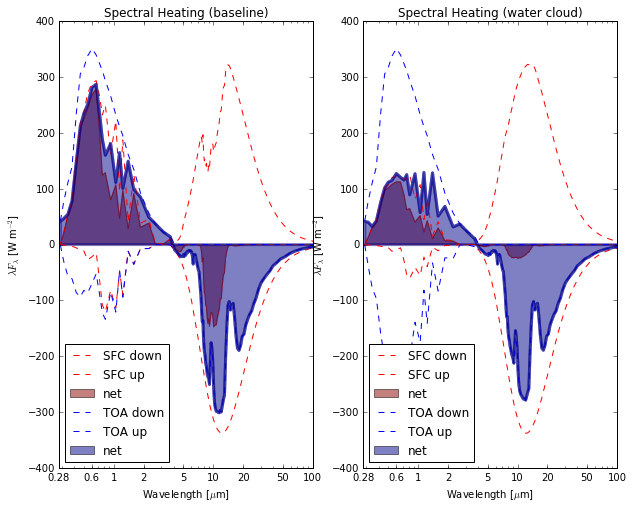

In [18]:
subplot(121)
plot_flux(get_spectral_flux('Tropical',0), get_spectral_flux('Tropical',100))
title('Spectral Heating (baseline)')
subplot(122)
plot_flux(get_spectral_flux('Tropical',0,**cloud_settings), get_spectral_flux('Tropical',100,**cloud_settings))
title('Spectral Heating (water cloud)')

The downwelling longwave at the surface looks more like blackbody emission. The upwelling shortwave at the TOA has increased significantly in the visible band, probably reflection from the cloud. This seems to happen at the expense of surface shortwave radiation, which is dimmer and so is the reflection.

### Heating Rates

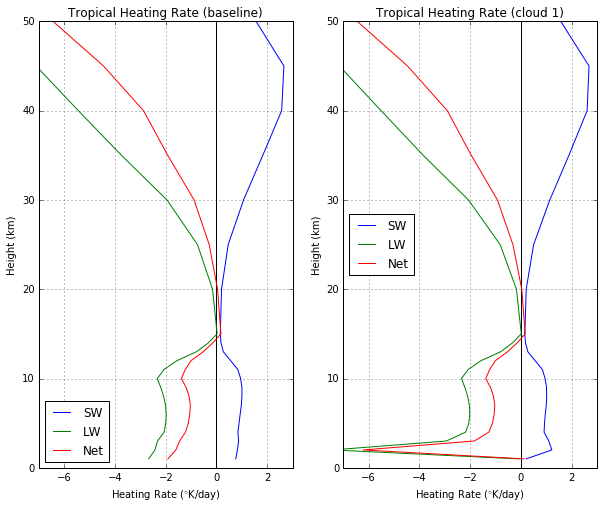

In [19]:
subplot(121)
plot_heating('Tropical')
title('Tropical Heating Rate (baseline)')
subplot(122)
plot_heating('Tropical', **cloud_settings)
title('Tropical Heating Rate (cloud 1)')

There is a drastic decrease in LW heating rate directly above the cloud.

### Spectral Heating Rates

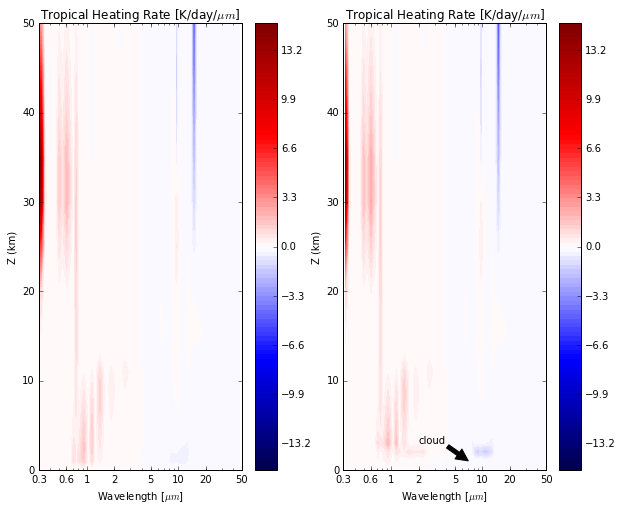

In [21]:
subplot(121)
plot_spectral_heating('Tropical')
subplot(122)
plot_spectral_heating('Tropical', **cloud_settings)
annotate('cloud', xy=(7,1), xytext=(2, 3), arrowprops=dict(facecolor='black'))

The cloud seems to mainly affect the heating rate above the cloud. A decrease in heating is observed in the spectral range from ~7um to ~14um

# Moving the cloud layer to 10.0 km and changing the cloud particle type to “spherical ice”

In [22]:
cloud_settings2 = dict(nclouds=1, icthk=3, cldwcl=0.07, cldphase1=8, cldtau=10.0, cldtop=10.0)

### SW

In [23]:
save_table(get_table('Tropical','SW', **cloud_settings2) 
 - get_table('Tropical','SW'), 'TropicalSWcloud2.tex')

Tropical                
        SWup  SWdown   SWnet
TOA   158.75    0.00 -158.75
SFC   -37.59 -166.39 -128.82

More upwelling shortwave at TOA, probably from higher albedo caused by cloud.
Decrease in downwelling shortwave at surface. Probably because in the shadow of the cloud it is a bit dimmer.

### LW

In [25]:
save_table(get_table('Tropical','LW',**cloud_settings2) 
 - get_table('Tropical','LW'),'TropicalLWcloud2.tex')

Tropical               
        LWup LWdown   LWnet
TOA  -139.63   0.00  139.63
SFC     0.00  14.45   14.45

Large decrease of upwelling longwave at TOA, probably because the cloud is absorbing it.
Increase in downwelling longwave, cloud cover probably traps heat, increasing temperatures in lower atmosphere.

### Combined

In [26]:
save_table(get_table('Tropical','COMBINED',**cloud_settings2) 
 - get_table('Tropical','COMBINED'), 'TropicalCOMBcloud2.tex')

Tropical                         
    COMBINEDup COMBINEDdown COMBINEDnet
TOA      19.12         0.00      -19.12
SFC     -37.59      -151.94     -114.37

The cloud seems to cause much less energy to impinge upon the surface, with the decrease in shortwave outweighing the increase in longwave.

### Spectral Flux

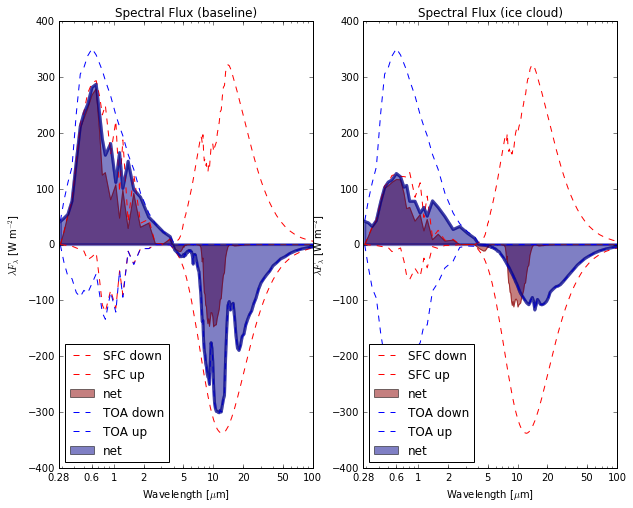

In [27]:
subplot(122)
plot_flux(get_spectral_flux('Tropical',0,**cloud_settings2),
          get_spectral_flux('Tropical',100,**cloud_settings2))
title('Spectral Flux (ice cloud)')
subplot(121)
plot_flux(get_spectral_flux('Tropical',0),
          get_spectral_flux('Tropical',100))
title('Spectral Flux (baseline)')

Effect on the shortwave looks very similar to the effect from the low cloud.
Dimmer at the surface, more incoming visible light being reflected back out to space.
The clouds effect on surface longwave seems to be limited, but significantly affects upwelling longwave at the TOA. The longwave radiation escaping to space looks to be radiating from the cloud, without much absorption between emission and the TOA. The cloud looks much colder than the surface.

### Heating Rates

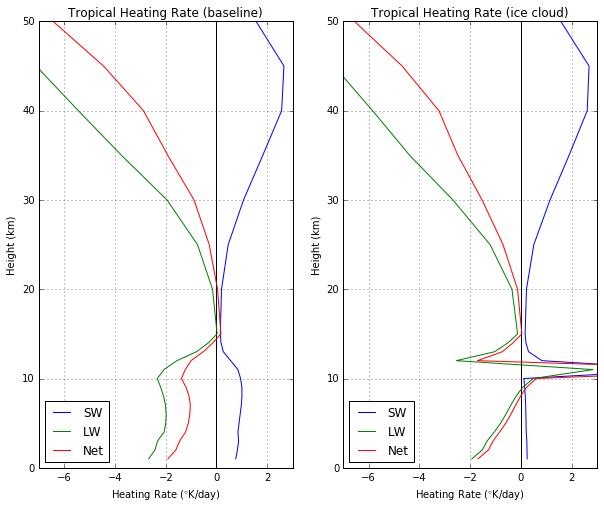

In [28]:
subplot(121)
plot_heating('Tropical')
title('Tropical Heating Rate (baseline)')
subplot(122)
plot_heating('Tropical', **cloud_settings2)
title('Tropical Heating Rate (ice cloud)')

Here we can actually see the increase in longwave heating rate below the cloud and the corresponding decrease above the cloud. Normally at 10km LW heating is -1, but with the cloud it is slightly above 0. Inside the cloud there is a lot of longwave heating. You can also see how shortwave heating is decreased below the cloud, but very high inside the cloud. Much of the shortwave is being absorbed by the cloud.

### Spectral Heating Rates

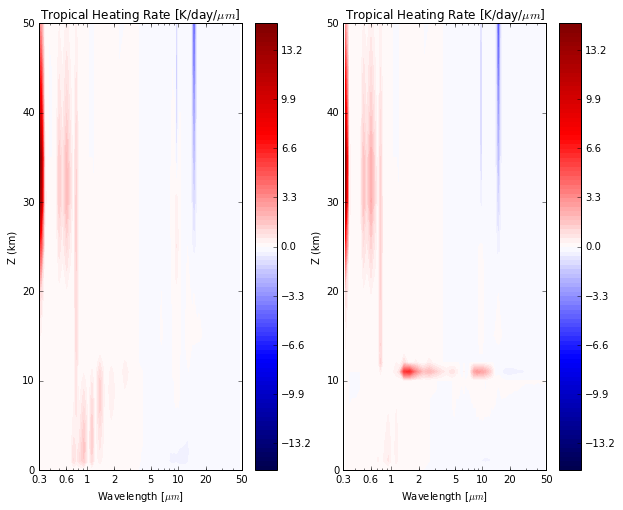

In [30]:
subplot(121)
plot_spectral_heating('Tropical')
subplot(122)
plot_spectral_heating('Tropical', **cloud_settings2)

Here you can see the cloud heating by contributions in the NIR and Thermal IR bands

## Bigger plots

In [51]:
rcParams['figure.figsize'] = (25,20)

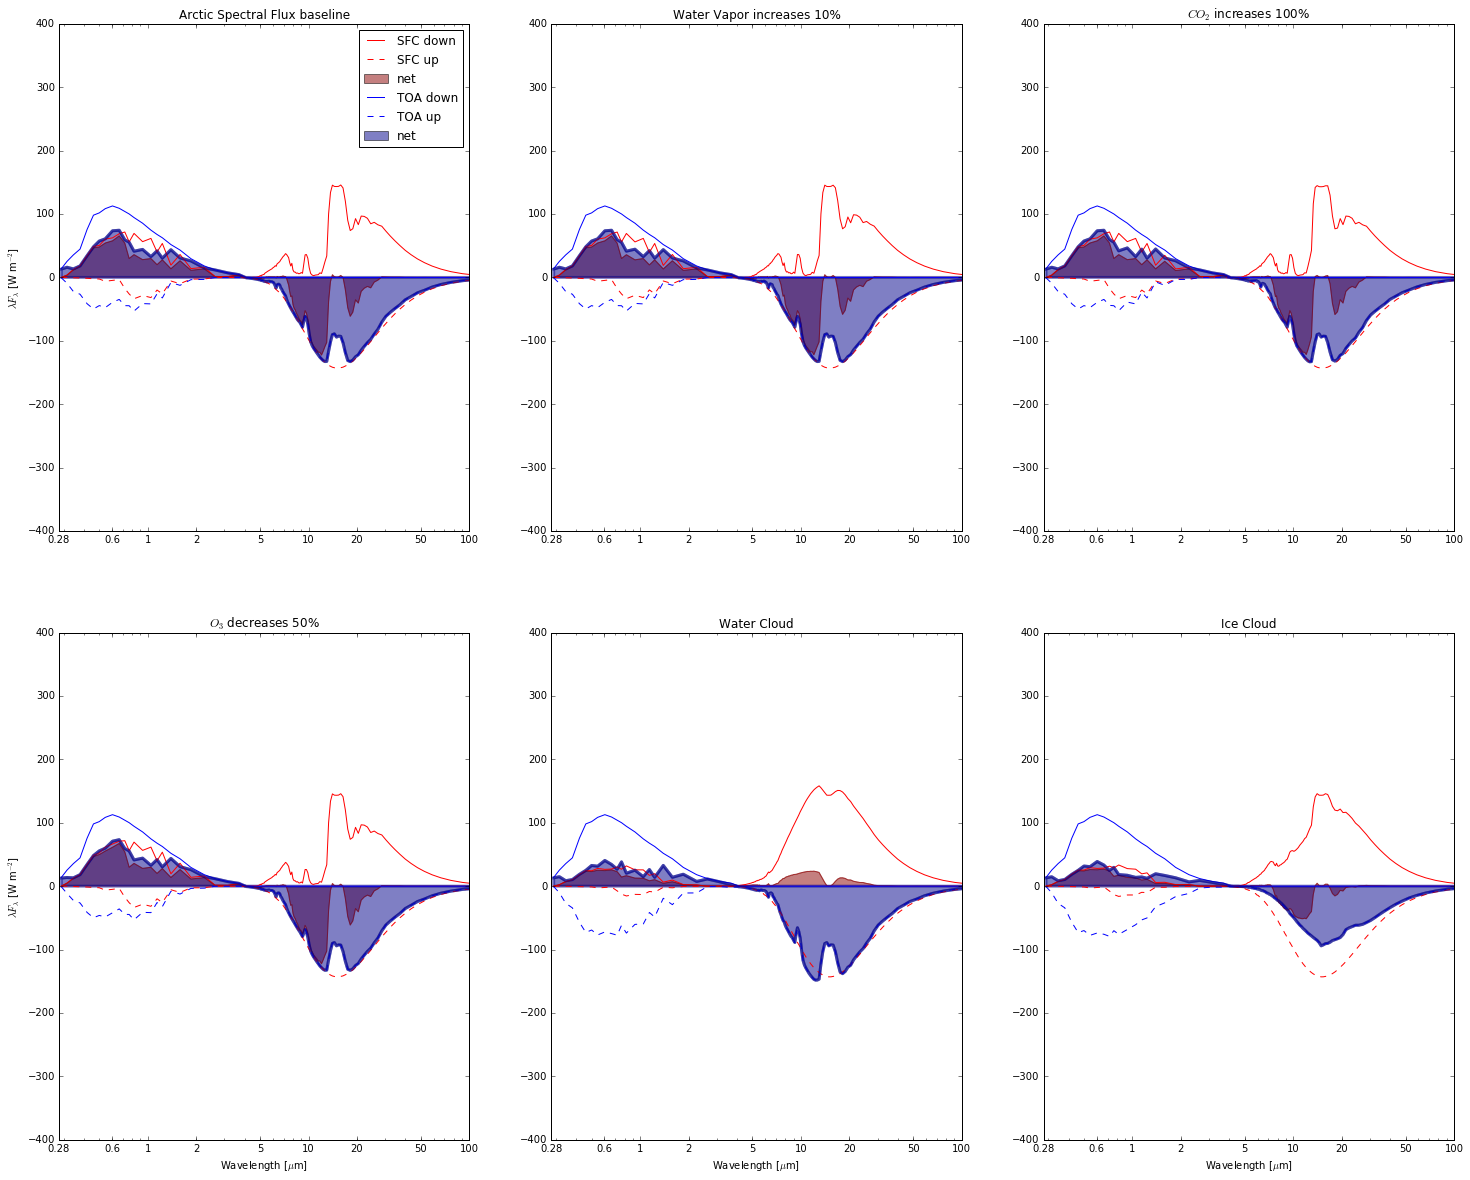

In [64]:
subplot(231)
plot_flux(get_spectral_flux('Arctic',0), get_spectral_flux('Arctic',100))
title('Arctic Spectral Flux baseline')
xlabel('')
subplot(232)
plot_flux(get_spectral_flux('Arctic',0, frwv=1.1, frwv2=1.1), get_spectral_flux('Arctic',100,frwv=1.1, frwv2=1.1))
gca().get_legend().remove()
title('Water Vapor increases 10%')
ylabel('')
xlabel('')
subplot(233)
plot_flux(get_spectral_flux('Arctic',0, frco2=2.0), get_spectral_flux('Arctic',100,frwv=2.0, frwv2=2.0))
gca().get_legend().remove()
title('$CO_2$ increases 100%')
ylabel('')
xlabel('')
subplot(234)
plot_flux(get_spectral_flux('Arctic',0, fro3=0.5), get_spectral_flux('Arctic',100,fro3=0.5))
gca().get_legend().remove()
title('$O_3$ decreases 50%')
subplot(235)
plot_flux(get_spectral_flux('Arctic',0, **cloud_settings), get_spectral_flux('Arctic',100,**cloud_settings))
gca().get_legend().remove()
title('Water Cloud')
ylabel('')
subplot(236)
plot_flux(get_spectral_flux('Arctic',0, **cloud_settings2), get_spectral_flux('Arctic',100,**cloud_settings2))
gca().get_legend().remove()
title('Ice Cloud')
ylabel('')

(-100, 100)

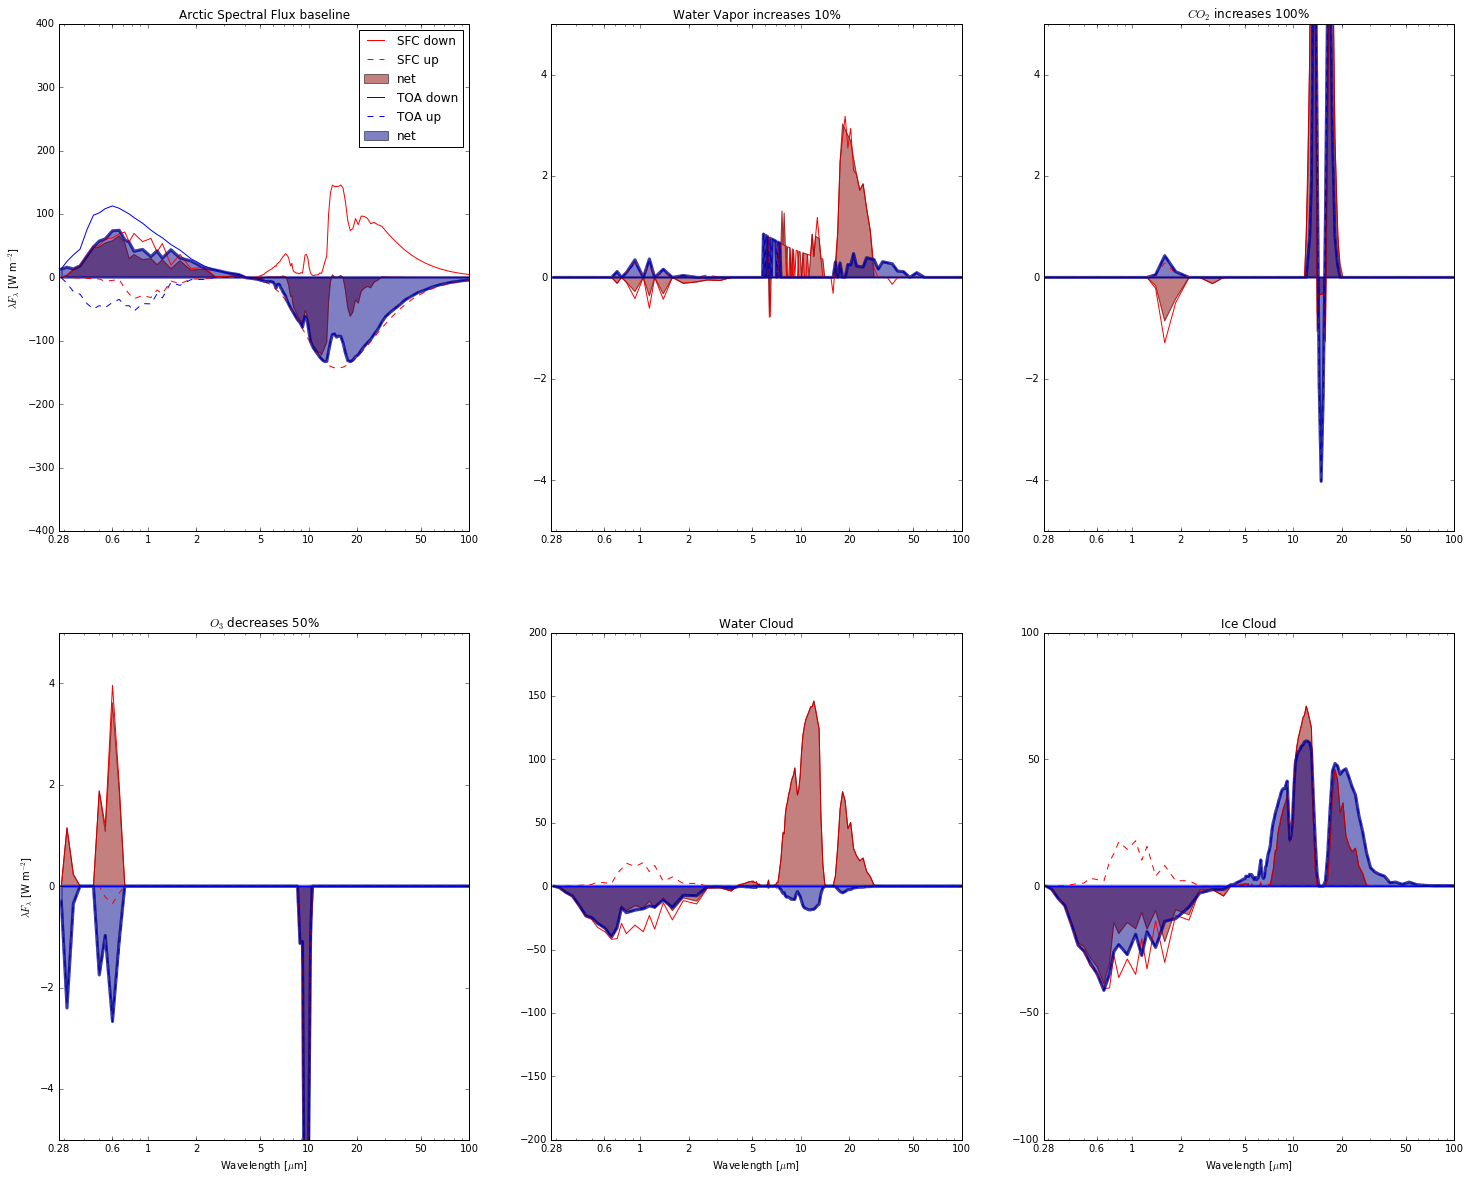

In [100]:
baseline_arctic = (get_spectral_flux('Arctic',0), get_spectral_flux('Arctic',100))
subplot(231)
plot_flux(*baseline_arctic)
title('Arctic Spectral Flux baseline')
xlabel('')

subplot(232)
plot_flux(get_spectral_flux('Arctic',0, frwv=1.1, frwv2=1.1)-baseline_arctic[0],
          get_spectral_flux('Arctic',100,frwv=1.1, frwv2=1.1)-baseline_arctic[1])
gca().get_legend().remove()
title('Water Vapor increases 10%')
ylabel('')
xlabel('')
ylim([-5,5])

subplot(233)
plot_flux(get_spectral_flux('Arctic',0, frco2=2.0)-baseline_arctic[0],
          get_spectral_flux('Arctic',100,frco2=2.0)-baseline_arctic[1])
gca().get_legend().remove()
title('$CO_2$ increases 100%')
ylabel('')
xlabel('')
ylim([-5,5])

subplot(234)
plot_flux(get_spectral_flux('Arctic',0, fro3=0.5)-baseline_arctic[0],
          get_spectral_flux('Arctic',100,fro3=0.5)-baseline_arctic[1])
gca().get_legend().remove()
title('$O_3$ decreases 50%')
ylim([-5,5])

subplot(235)
plot_flux(get_spectral_flux('Arctic',0, **cloud_settings)-baseline_arctic[0],
          get_spectral_flux('Arctic',100,**cloud_settings)-baseline_arctic[1])
gca().get_legend().remove()
title('Water Cloud')
ylabel('')
ylim([-200,200])

subplot(236)
plot_flux(get_spectral_flux('Arctic',0, **cloud_settings2)-baseline_arctic[0],
          get_spectral_flux('Arctic',100,**cloud_settings2)-baseline_arctic[1])
gca().get_legend().remove()
title('Ice Cloud')
ylabel('')
ylim([-100,100])

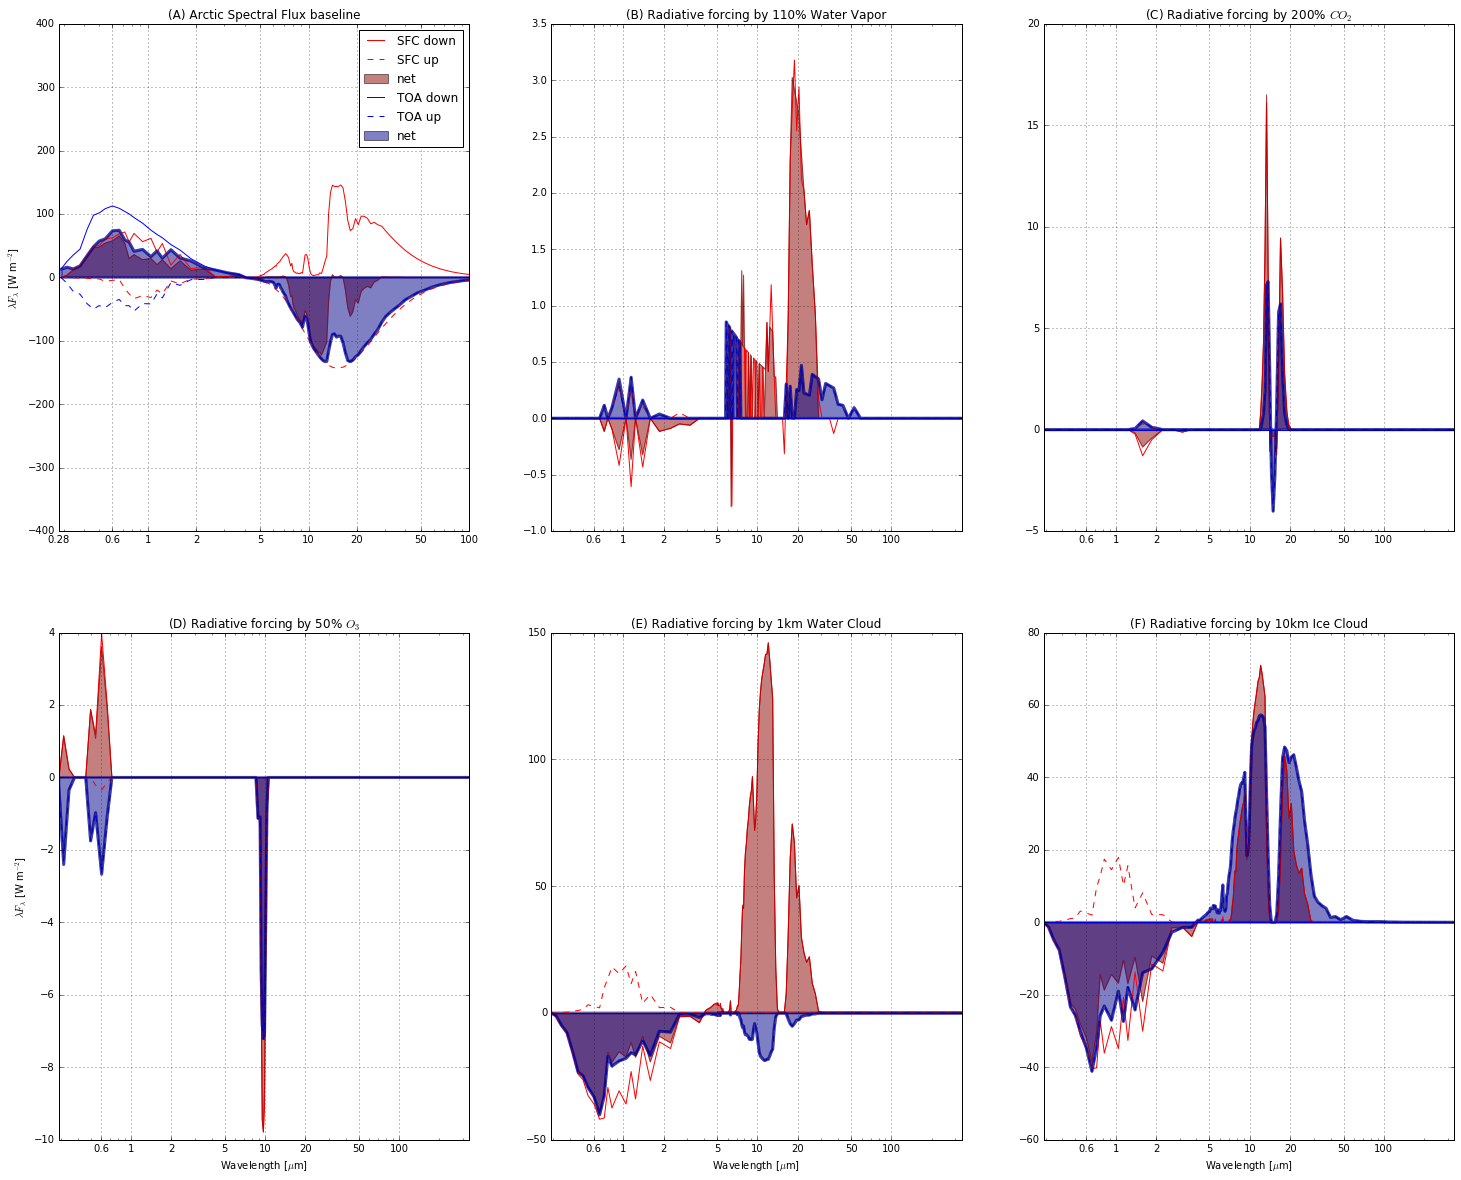

In [136]:
baseline_arctic = (get_spectral_flux('Arctic',0), get_spectral_flux('Arctic',100))

subplot(231)
plot_flux(*baseline_arctic)
title('(A) Arctic Spectral Flux baseline')
xlabel('')

subplot(232)
plot_flux(get_spectral_flux('Arctic',0, frwv=1.1, frwv2=1.1)-baseline_arctic[0],
          get_spectral_flux('Arctic',100,frwv=1.1, frwv2=1.1)-baseline_arctic[1])
gca().get_legend().remove()
title('(B) Radiative forcing by 110% Water Vapor')
ylabel('')
xlabel('')
autoscale('y')

subplot(233)
plot_flux(get_spectral_flux('Arctic',0, frco2=2.0)-baseline_arctic[0],
          get_spectral_flux('Arctic',100,frco2=2.0)-baseline_arctic[1])
gca().get_legend().remove()
title('(C) Radiative forcing by 200% $CO_2$')
ylabel('')
xlabel('')
autoscale('y')

subplot(234)
plot_flux(get_spectral_flux('Arctic',0, fro3=0.5)-baseline_arctic[0],
          get_spectral_flux('Arctic',100,fro3=0.5)-baseline_arctic[1])
gca().get_legend().remove()
title('(D) Radiative forcing by 50% $O_3$')
autoscale('y')

subplot(235)
plot_flux(get_spectral_flux('Arctic',0, **cloud_settings)-baseline_arctic[0],
          get_spectral_flux('Arctic',100,**cloud_settings)-baseline_arctic[1])
gca().get_legend().remove()
title('(E) Radiative forcing by 1km Water Cloud')
ylabel('')
autoscale('y')

subplot(236)
plot_flux(get_spectral_flux('Arctic',0, **cloud_settings2)-baseline_arctic[0],
          get_spectral_flux('Arctic',100,**cloud_settings2)-baseline_arctic[1])
gca().get_legend().remove()
title('(F) Radiative forcing by 10km Ice Cloud')
ylabel('')
autoscale('y')

savefig('./figures/arctic_flux.eps')

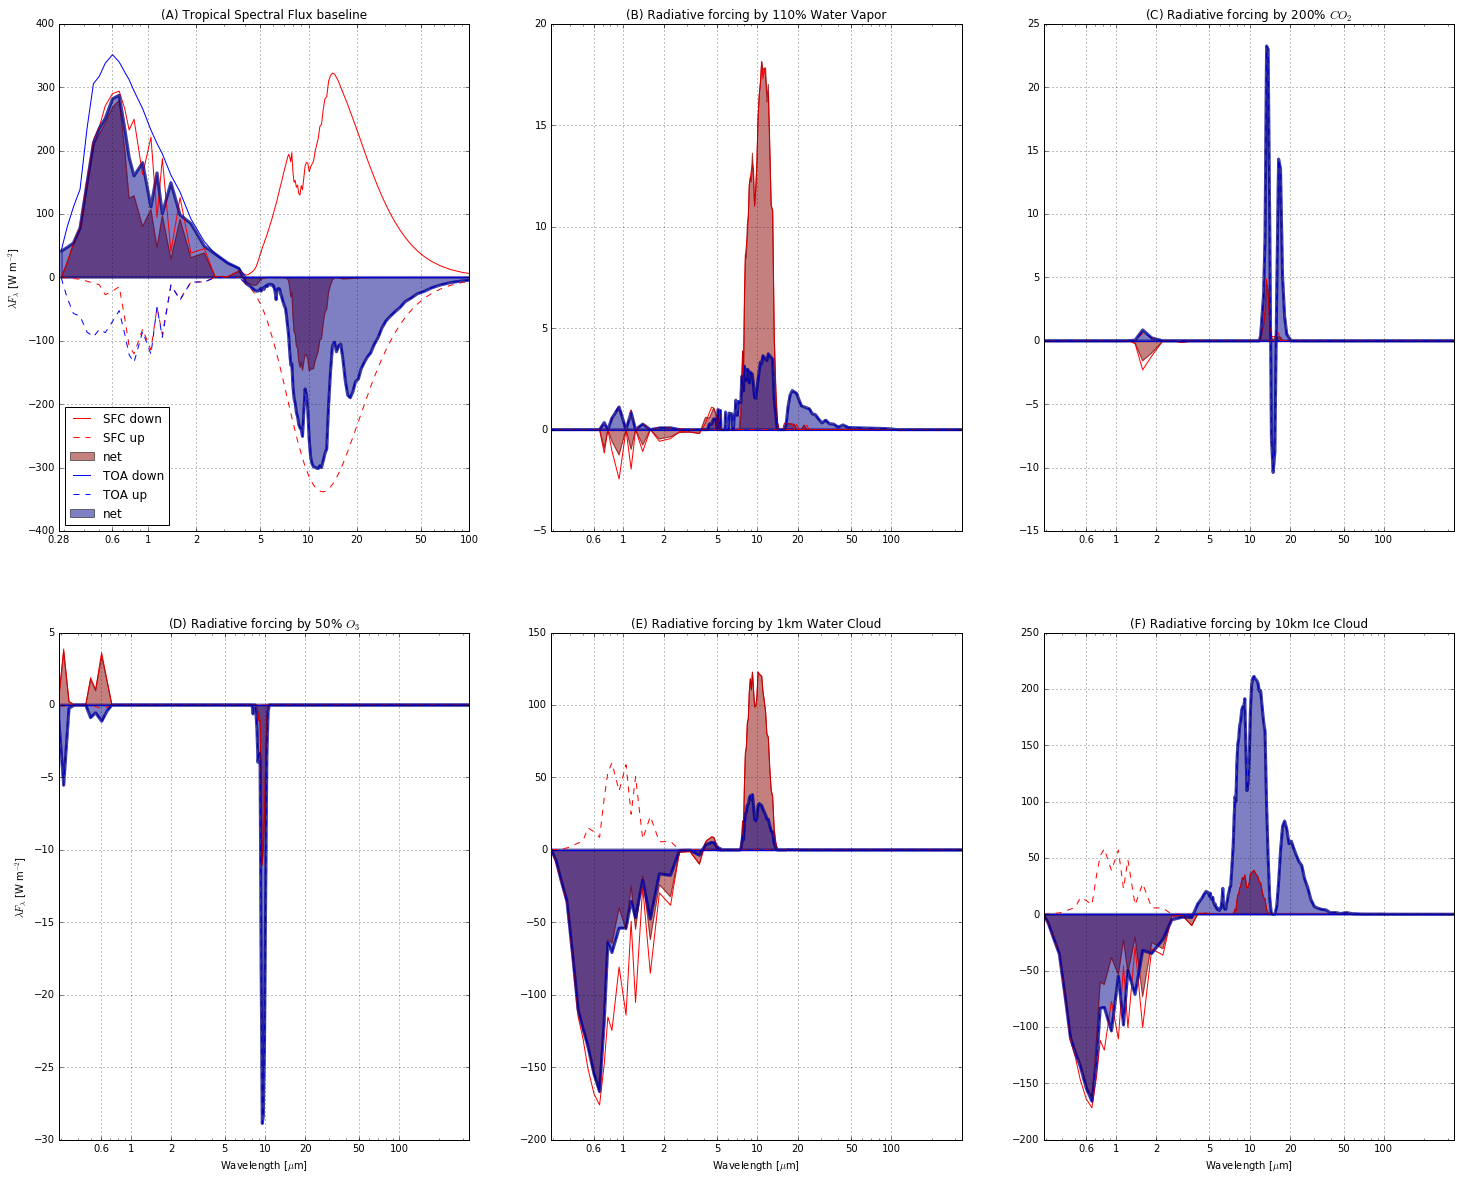

In [137]:
baseline_tropical = (get_spectral_flux('Tropical',0), get_spectral_flux('Tropical',100))

subplot(231)
plot_flux(*baseline_tropical)
title('(A) Tropical Spectral Flux baseline')
xlabel('')

subplot(232)
plot_flux(get_spectral_flux('Tropical',0, frwv=1.1, frwv2=1.1)-baseline_tropical[0],
          get_spectral_flux('Tropical',100,frwv=1.1, frwv2=1.1)-baseline_tropical[1])
gca().get_legend().remove()
title('(B) Radiative forcing by 110% Water Vapor')
ylabel('')
xlabel('')
autoscale('y')

subplot(233)
plot_flux(get_spectral_flux('Tropical',0, frco2=2.0)-baseline_tropical[0],
          get_spectral_flux('Tropical',100,frco2=2.0)-baseline_tropical[1])
gca().get_legend().remove()
title('(C) Radiative forcing by 200% $CO_2$')
ylabel('')
xlabel('')
autoscale('y')

subplot(234)
plot_flux(get_spectral_flux('Tropical',0, fro3=0.5)-baseline_tropical[0],
          get_spectral_flux('Tropical',100,fro3=0.5)-baseline_tropical[1])
gca().get_legend().remove()
title('(D) Radiative forcing by 50% $O_3$')
autoscale('y')

subplot(235)
plot_flux(get_spectral_flux('Tropical',0, **cloud_settings)-baseline_tropical[0],
          get_spectral_flux('Tropical',100,**cloud_settings)-baseline_tropical[1])
gca().get_legend().remove()
title('(E) Radiative forcing by 1km Water Cloud')
ylabel('')
autoscale('y')

subplot(236)
plot_flux(get_spectral_flux('Tropical',0, **cloud_settings2)-baseline_tropical[0],
          get_spectral_flux('Tropical',100,**cloud_settings2)-baseline_tropical[1])
gca().get_legend().remove()
title('(F) Radiative forcing by 10km Ice Cloud')
ylabel('')
autoscale('y')
savefig('./figures/tropical_flux.eps')

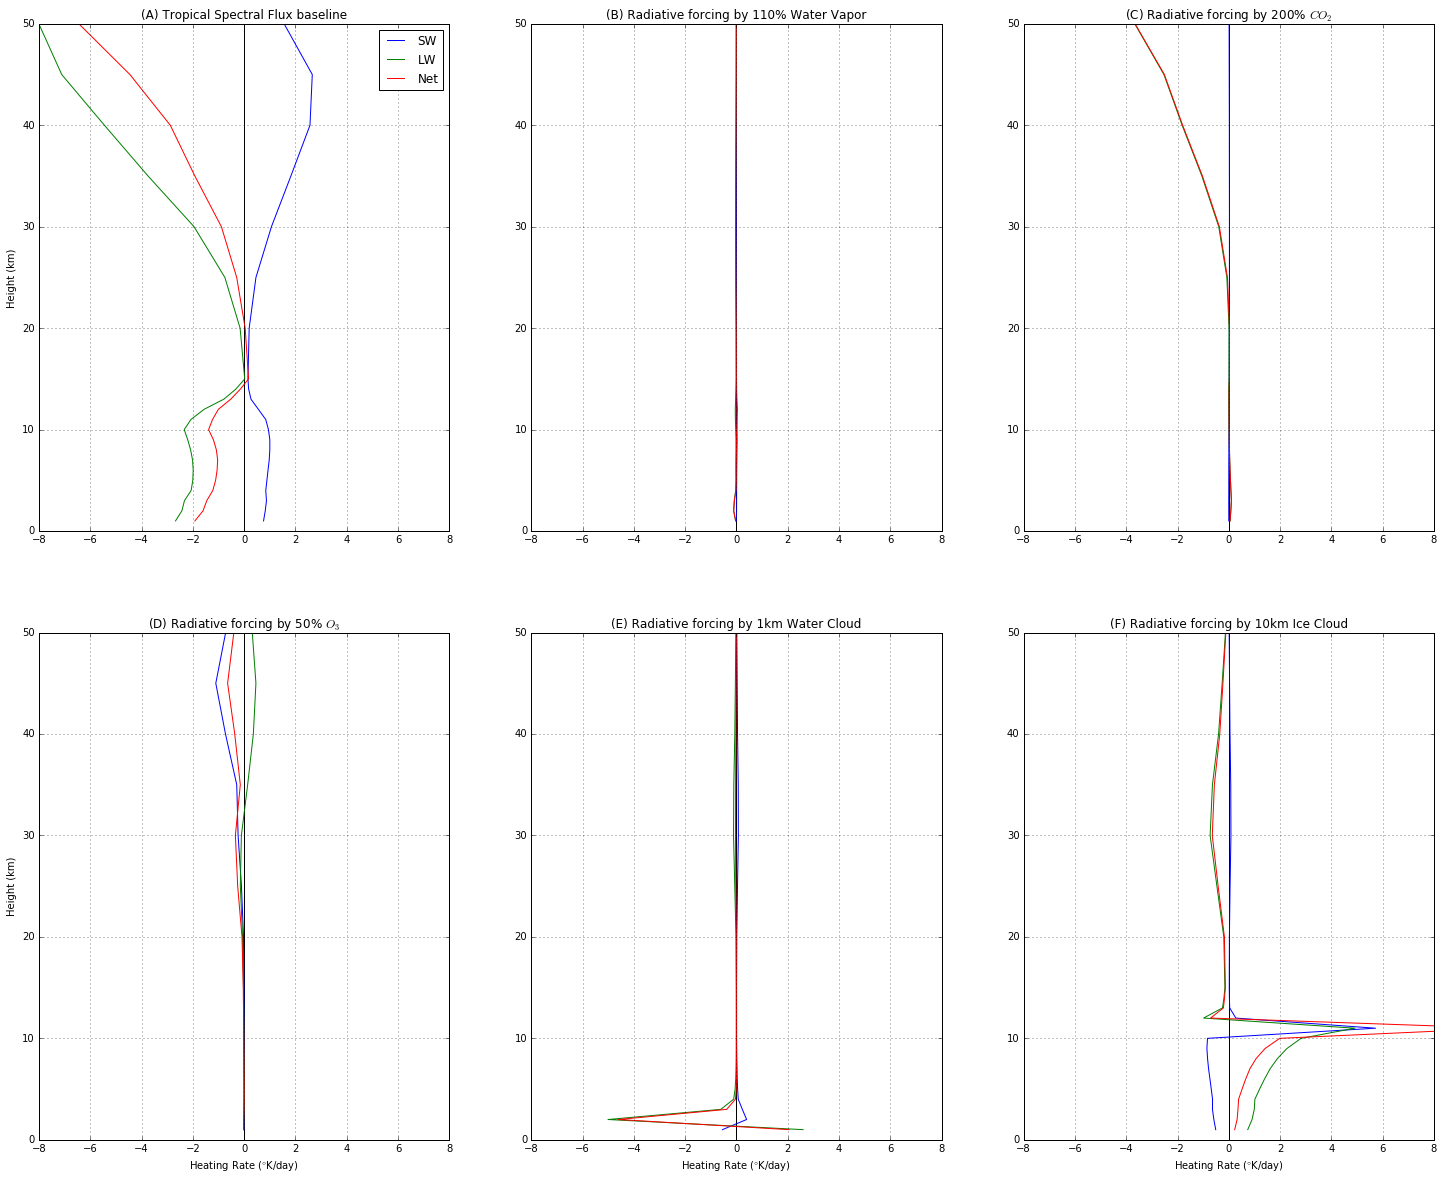

In [138]:
subplot(231)
plot_heating('Tropical')
title('(A) Tropical Spectral Flux baseline')
xlabel('')
xlim([-8,8])

subplot(232)
plot_heating_forcing('Tropical', frwv=1.1, frwv2=1.1)
gca().get_legend().remove()
title('(B) Radiative forcing by 110% Water Vapor')
ylabel('')
xlabel('')

subplot(233)
plot_heating_forcing('Tropical', frco2=2.0)
gca().get_legend().remove()
title('(C) Radiative forcing by 200% $CO_2$')
ylabel('')
xlabel('')

subplot(234)
plot_heating_forcing('Tropical', fro3=0.5)
gca().get_legend().remove()
title('(D) Radiative forcing by 50% $O_3$')

subplot(235)
plot_heating_forcing('Tropical', **cloud_settings)
gca().get_legend().remove()
title('(E) Radiative forcing by 1km Water Cloud')
ylabel('')

subplot(236)
plot_heating_forcing('Tropical', **cloud_settings2)
gca().get_legend().remove()
title('(F) Radiative forcing by 10km Ice Cloud')
ylabel('')
savefig('./figures/tropical_heating.eps')

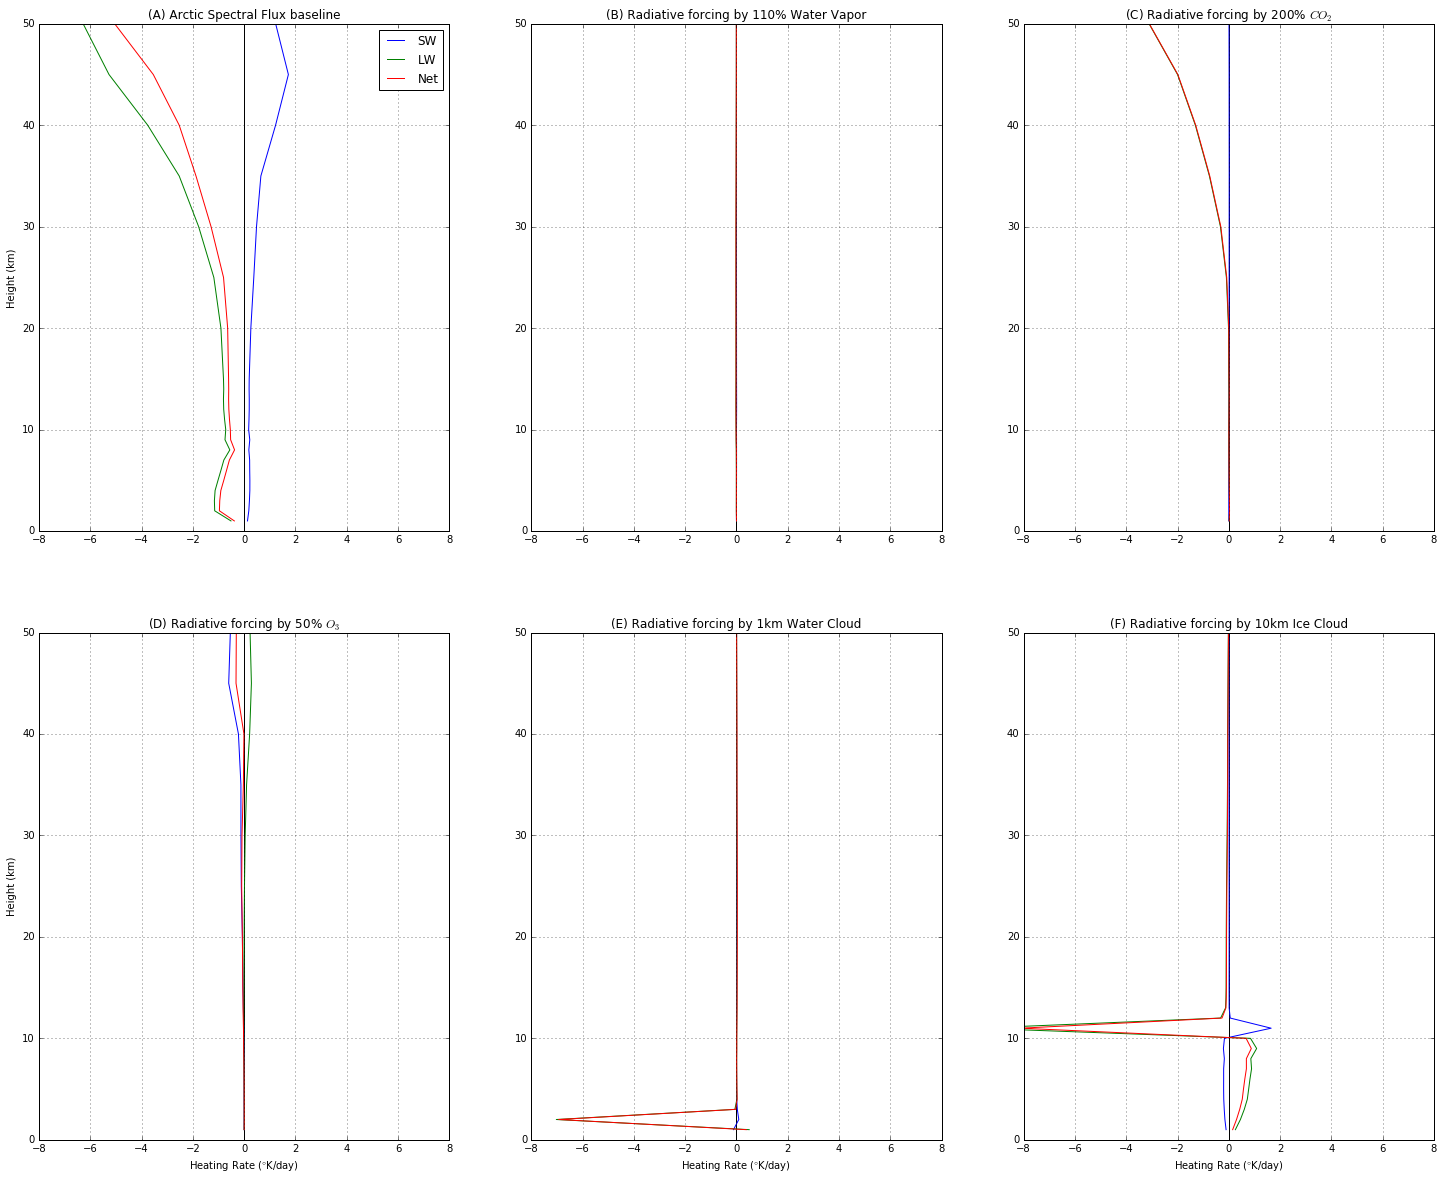

In [140]:
subplot(231)
plot_heating('Arctic')
title('(A) Arctic Spectral Flux baseline')
xlabel('')
xlim([-8,8])

subplot(232)
plot_heating_forcing('Arctic', frwv=1.1, frwv2=1.1)
gca().get_legend().remove()
title('(B) Radiative forcing by 110% Water Vapor')
ylabel('')
xlabel('')

subplot(233)
plot_heating_forcing('Arctic', frco2=2.0)
gca().get_legend().remove()
title('(C) Radiative forcing by 200% $CO_2$')
ylabel('')
xlabel('')

subplot(234)
plot_heating_forcing('Arctic', fro3=0.5)
gca().get_legend().remove()
title('(D) Radiative forcing by 50% $O_3$')

subplot(235)
plot_heating_forcing('Arctic', **cloud_settings)
gca().get_legend().remove()
title('(E) Radiative forcing by 1km Water Cloud')
ylabel('')

subplot(236)
plot_heating_forcing('Arctic', **cloud_settings2)
gca().get_legend().remove()
title('(F) Radiative forcing by 10km Ice Cloud')
ylabel('')
savefig('./figures/arctic_heating.eps')